In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import geopandas as gpd
import seaborn as sns
from scipy.stats import linregress as LinReg
from shapely.geometry import Polygon

# House Data

In [5]:
house_df = pd.read_csv('../Data/1976-2022-house.csv')
print(house_df.shape)
house_df = house_df[['year', 'state_po', 'party', 'candidatevotes', 'totalvotes', 'unofficial', 'district']]
house_df.head()

(32452, 20)


,year,state_po,party,candidatevotes,totalvotes,unofficial,district
0,1976,AL,DEMOCRAT,58906,157170,False,1
1,1976,AL,REPUBLICAN,98257,157170,False,1
2,1976,AL,NaN,7,157170,False,1
3,1976,AL,DEMOCRAT,66288,156362,False,2
4,1976,AL,REPUBLICAN,90069,156362,False,2


In [6]:
# Won't count votes if the party is NaN, so replace with OTHER
house_df['party'].fillna('OTHER', inplace=True)
house_df.head()

C:\Users\meowm\AppData\Local\Temp\ipykernel_34452\2497990077.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  house_df['party'].fillna('OTHER', inplace=True)


,year,state_po,party,candidatevotes,totalvotes,unofficial,district
0,1976,AL,DEMOCRAT,58906,157170,False,1
1,1976,AL,REPUBLICAN,98257,157170,False,1
2,1976,AL,OTHER,7,157170,False,1
3,1976,AL,DEMOCRAT,66288,156362,False,2
4,1976,AL,REPUBLICAN,90069,156362,False,2


In [7]:
# Only want elections that are official and on 2020 or 2022
house_df_2020_on = house_df.query('year >= 2020 and unofficial == False')
print(house_df_2020_on.shape)
house_df_2020_on.head()

(2816, 7)


,year,state_po,party,candidatevotes,totalvotes,unofficial,district
29636,2020,AL,DEMOCRAT,116949,329075,False,1
29637,2020,AL,REPUBLICAN,211825,329075,False,1
29638,2020,AL,OTHER,301,329075,False,1
29639,2020,AL,REPUBLICAN,197996,303569,False,2
29640,2020,AL,DEMOCRAT,105286,303569,False,2


In [8]:
# We don't care about the districts so sum the votes for a party across all districts
votes_by_year_state_party = house_df_2020_on.groupby(['year', 'state_po', 'party'])['candidatevotes'].sum()
votes_by_year_state_party

year  state_po  party       
2020  AK        DEMOCRAT        159856
                OTHER             1183
                REPUBLICAN      192126
      AL        DEMOCRAT        608809
                OTHER            26838
                                 ...  
2022  WY        CONSTITUTION      4505
                DEMOCRAT         47250
                LIBERTARIAN       5420
                OTHER             8817
                REPUBLICAN      132206
Name: candidatevotes, Length: 469, dtype: int64

In [9]:
list(votes_by_year_state_party[2022]['SD'].items())

[('LIBERTARIAN', 74020), ('REPUBLICAN', 253821)]

In [10]:
votes_by_year_state_party[2020]['SD']

party
LIBERTARIAN     75748
REPUBLICAN     321984
Name: candidatevotes, dtype: int64

In [11]:
years = [2020, 2022]
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
        'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
        'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
        'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
print(len(states))
main_parties = ['DEMOCRAT', 'REPUBLICAN']

50


In [12]:
# make a dictionary where the first key:value is year:rest
# next is state:rest
# final is one of three parties (Democrat, Republican, Other) and their vote counts
# votes => first is year:states => states:parties => parties:votes
# votes[year][state][party] = votes
votes = {}
for year in years:
    votes[year] = {}
    for state in states:
        votes[year][state] = defaultdict(int)
        parties = list(votes_by_year_state_party[year][state].keys())
        for party in parties:
            if party in main_parties:
                votes[year][state][party] += votes_by_year_state_party[year][state][party]
            else:
                flag = True
                for mparty in main_parties:
                    if mparty in party:
                        votes[year][state][mparty] += votes_by_year_state_party[year][state][party]
                        flag = False
                        break
                
                if flag:
                    votes[year][state]['OTHER'] += votes_by_year_state_party[year][state][party]
        votes[year][state] = dict(votes[year][state])
        if 'OTHER' not in votes[year][state].keys():
            votes[year][state]['OTHER'] = 0
        if 'DEMOCRAT' not in votes[year][state].keys():
            votes[year][state]['DEMOCRAT'] = 0
        if 'REPUBLICAN' not in votes[year][state].keys():
            votes[year][state]['REPUBLICAN'] = 0

print(votes[2020])

{'AL': {'DEMOCRAT': 608809, 'OTHER': 26838, 'REPUBLICAN': 1416012}, 'AK': {'DEMOCRAT': 159856, 'OTHER': 1183, 'REPUBLICAN': 192126}, 'AZ': {'DEMOCRAT': 1629337, 'REPUBLICAN': 1638596, 'OTHER': 316}, 'AR': {'DEMOCRAT': 330485, 'OTHER': 20645, 'REPUBLICAN': 828266}, 'CA': {'DEMOCRAT': 11084234, 'REPUBLICAN': 5640667, 'OTHER': 0}, 'CO': {'OTHER': 107650, 'DEMOCRAT': 1679052, 'REPUBLICAN': 1378248}, 'CT': {'DEMOCRAT': 1022792, 'OTHER': 73485, 'REPUBLICAN': 676650}, 'DE': {'DEMOCRAT': 281382, 'OTHER': 10496, 'REPUBLICAN': 196392}, 'FL': {'DEMOCRAT': 4942287, 'OTHER': 53340, 'REPUBLICAN': 5469163}, 'GA': {'DEMOCRAT': 2393089, 'REPUBLICAN': 2490396, 'OTHER': 126}, 'HI': {'OTHER': 69807, 'DEMOCRAT': 354762, 'REPUBLICAN': 155215}, 'ID': {'OTHER': 32973, 'DEMOCRAT': 255531, 'REPUBLICAN': 561405}, 'IL': {'DEMOCRAT': 3355487, 'OTHER': 104403, 'REPUBLICAN': 2416929}, 'IN': {'DEMOCRAT': 1194901, 'OTHER': 62798, 'REPUBLICAN': 1738745}, 'IA': {'DEMOCRAT': 762271, 'OTHER': 78579, 'REPUBLICAN': 859418},

In [13]:
print(votes[2020]['AL'])
# print(len(house_df_2020_on.query('year == 2020 and state_po == "AL"')))
# house_df_2020_on.query('year == 2020 and state_po == "AL"')

{'DEMOCRAT': 608809, 'OTHER': 26838, 'REPUBLICAN': 1416012}


# 2020 Census

In [14]:
census_df = pd.read_csv('../Data/2020-Census.csv')
print(census_df.shape)
census_df["POPULATION"] = census_df["POPULATION"].str.replace(',', '').astype(int)
print(census_df.shape)
census_df[["AREA", "POPULATION"]].head()

(54, 3)
(54, 3)


,AREA,POPULATION
0,Alabama,5024279
1,Alaska,733391
2,Arizona,7151502
3,Arkansas,3011524
4,California,39538223


In [15]:
# Turn the census_df into a series, indexed by state
census_df.set_index(census_df['CODE'], inplace=True)
census_arr = census_df['POPULATION']
print(census_arr['AL'])
print(len(census_arr))
print(census_arr.index)

5024279
54
Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
       'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
       'WV', 'WI', 'WY', 'TO', 'PR', 'TT'],
      dtype='object', name='CODE')


# COVID-19 Data

In [27]:
covid_df = pd.read_csv('../Data/COVID-19_Reported.csv')
print(covid_df.shape)

# New column where it is the combined adult and pediatric COVID confirmed cases
# Filling NaN values with 0s to make it possible 
covid_df['total_previous_day_cases'] = covid_df['previous_day_admission_adult_covid_confirmed'].fillna(0) + covid_df['previous_day_admission_pediatric_covid_confirmed'].fillna(0)
covid_df = covid_df[['date', 'state', 'total_previous_day_cases']]
covid_df.head()
# covid_df = covid_df[['state', 'date']]

(79823, 135)


,date,state,total_previous_day_cases
0,6/2/2021,PR,3.0
1,6/1/2021,ME,11.0
2,5/30/2021,MT,13.0
3,5/29/2021,AK,0.0
4,5/29/2021,MA,33.0


In [28]:
# Create month and year columns to properly add up and categorize the data
covid_df['month'] = covid_df['date'].str.split('/').str[0].astype(int)
covid_df['year'] = covid_df['date'].str.split('/').str[2].astype(int)

In [29]:
# Deaths by covid-19
cases_by_year_month_state = covid_df.groupby(['year', 'month', 'state'])['total_previous_day_cases'].sum()
print(cases_by_year_month_state[2020][3].keys())

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT',
       'WA', 'WI', 'WV', 'WY'],
      dtype='object', name='state')


In [30]:
# Checking if all of the states are in each month
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
        'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
        'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
        'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
len_states = []
for i in range(1, 13):
    potential = list(cases_by_year_month_state[2020][i].keys())
    flag = True
    state_count = 0
    for s in states:
        if s not in potential:
            flag = False
        else:
            state_count += 1
    len_states.append(state_count)

# For the first two months of 2020, all of the states are not reporting data yet, 
# so these months will be cut out, the rest are fine
len_states

[11, 16, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [31]:
cases_by_year_state = covid_df.groupby(['year', 'state'])['total_previous_day_cases'].sum()
cases_by_year_state[2020].keys()

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI',
       'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object', name='state')

# Notes after initial EDA
1. COVID
    - 50 States
    - VI (Virgin Islands)
    - DC
    - PR (Puerto Rico)
2. Census
    - 50 States
    - TO (Total Resident Pop)
    - TT (Total Pop (with PR))
    - DC
    - PR (Puerto Rico)
3. House Votes
    - 50 States

In [32]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
        'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
        'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
        'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
# states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
#         'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
#         'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 
#         'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
house_years = [2020, 2022]
parties = ["DEMOCRAT", "REPUBLICAN", "OTHER"]
covid_years = [2020, 2021, 2022, 2023]

In [33]:
# House Normalize
other_counter = 0
votes_norm = {}
for y in house_years:
    votes_norm[y] = {}
    for s in states:
        votes_norm[y][s] = {}
        for p in parties:
            if p in votes[y][s].keys():
                votes_norm[y][s][p] = votes[y][s][p] / census_arr[s]
            else:
                votes_norm[y][s][p] = 0
                other_counter += 1

        
print(sum(votes_norm[2020]['AK'].values()))
votes_norm[2020]['AK']


0.48155076896225885


{'DEMOCRAT': 0.21796831430982927,
 'REPUBLICAN': 0.2619693996790252,
 'OTHER': 0.001613054973404364}

In [34]:
votes_prop = {}
for y in house_years:
    votes_prop[y] = {}
    for s in states:
        votes_prop[y][s] = {}
        s_votes = sum(votes[y][s].values())
        for p in parties:
            votes_prop[y][s][p] = votes[y][s][p] / s_votes
votes_prop[2020]['AL']

{'DEMOCRAT': 0.29673985784187334,
 'REPUBLICAN': 0.6901790209776576,
 'OTHER': 0.013081121180469075}

In [35]:
total_votes = {}
for y in house_years:
    total_votes[y] = {}
    for s in states:
        total_votes[y][s] = sum(votes[y][s].values()) / census_arr[s]
min(total_votes[2020].values())

0.38062905412000925

In [36]:
# COVID Normalize
cases_norm = {}
for y in covid_years:
    cases_norm[y] = {}
    for s in states:
        cases_norm[y][s] = cases_by_year_state[y][s] / census_arr[s]

# Now a dictionary indexed year, state
cases_norm[2020]['AK']

0.002056201944119849

# Plotting
Normalized Data:  
    - votes_norm (indexed year, state)  
    - cases_norm (indexed year, state)

In [23]:
def plot_df(votes, cases, year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])

    return ret_df

In [24]:
def plot_df_specific(votes, cases, votes_year, cases_year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])

    return ret_df

In [25]:
votes[2020]['ND']

{'DEMOCRAT': 97970, 'OTHER': 12399, 'REPUBLICAN': 245229}

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3520221716.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

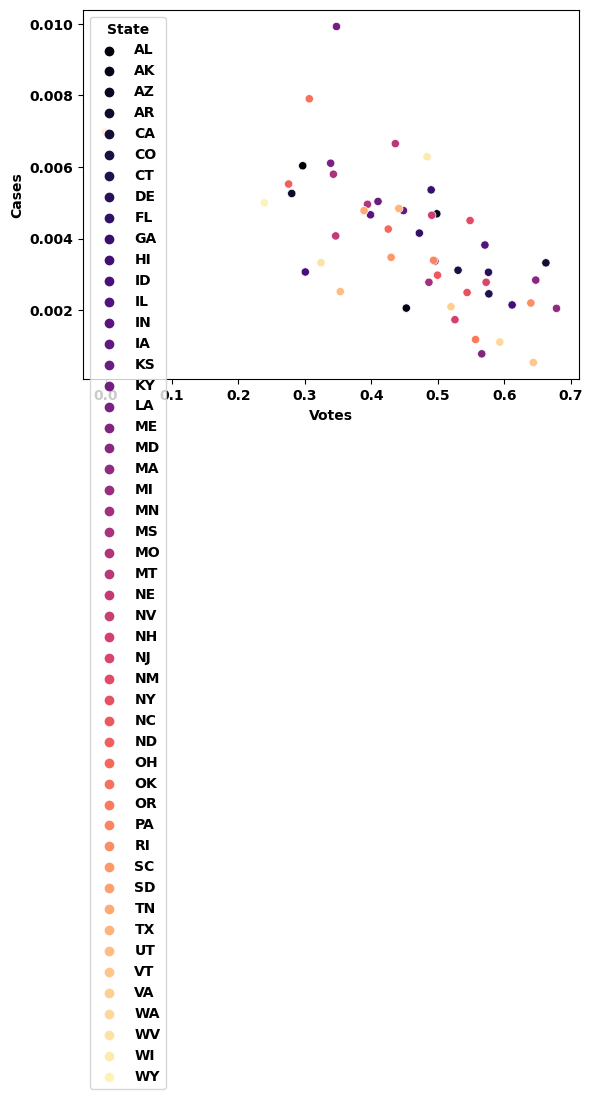

In [26]:
sns.scatterplot(plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'DEMOCRAT'), x='Votes', y='Cases', hue='State', palette='magma')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

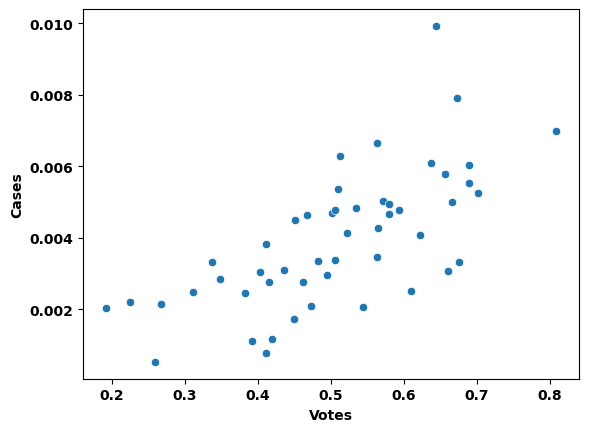

In [27]:
sns.scatterplot(plot_df(votes_prop, cases_norm, 2020, 'REPUBLICAN'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

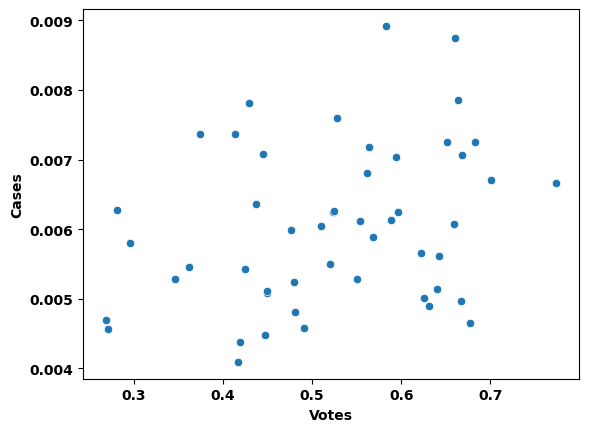

In [28]:
sns.scatterplot(plot_df(votes_prop, cases_norm, 2022, 'REPUBLICAN'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

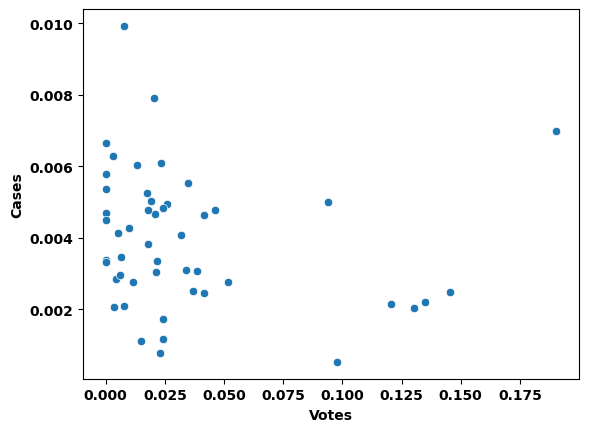

In [29]:
sns.scatterplot(plot_df(votes_prop, cases_norm, 2020, 'OTHER'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

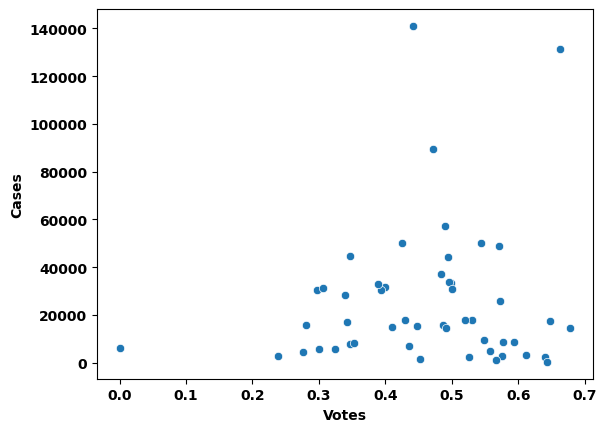

In [30]:
sns.scatterplot(plot_df(votes_prop, cases_by_year_state, 2020, 'DEMOCRAT'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

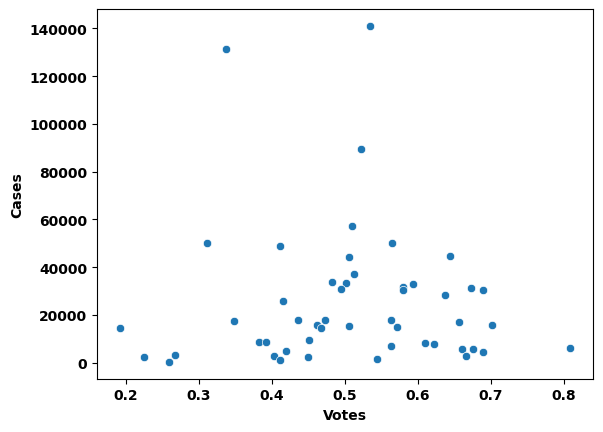

In [31]:
sns.scatterplot(plot_df(votes_prop, cases_by_year_state, 2020, 'REPUBLICAN'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

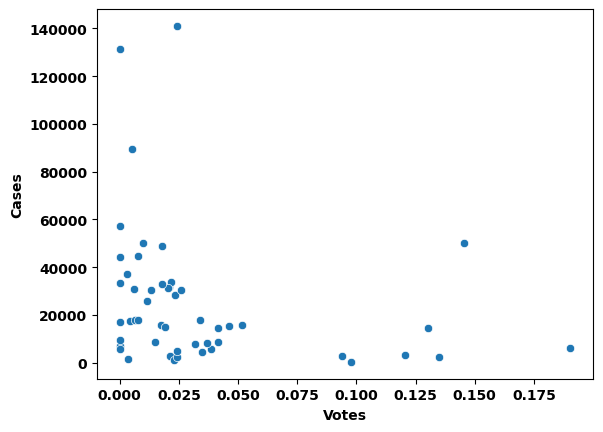

In [32]:
sns.scatterplot(plot_df(votes_prop, cases_by_year_state, 2020, 'OTHER'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

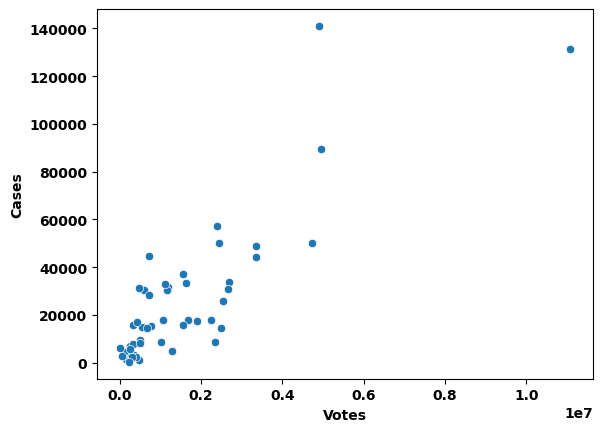

In [33]:
sns.scatterplot(plot_df(votes, cases_by_year_state, 2020, 'DEMOCRAT'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

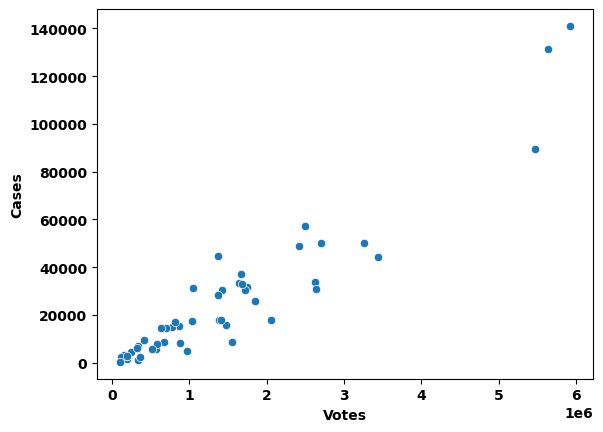

In [34]:
sns.scatterplot(plot_df(votes, cases_by_year_state, 2020, 'REPUBLICAN'), x='Votes', y='Cases')

C:\Users\meowm\AppData\Local\Temp\ipykernel_12184\3948341719.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])


<Axes: xlabel='Votes', ylabel='Cases'>

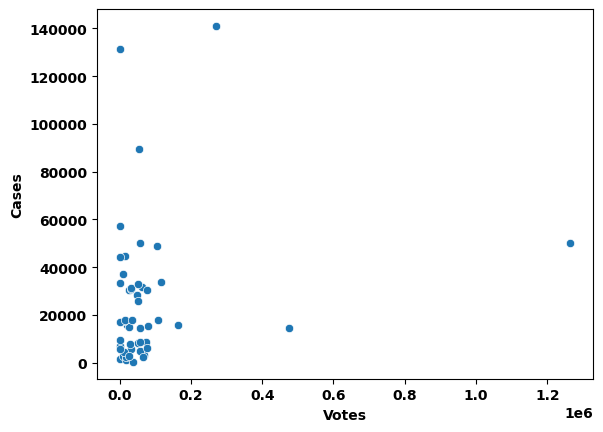

In [35]:
sns.scatterplot(plot_df(votes, cases_by_year_state, 2020, 'OTHER'), x='Votes', y='Cases')

In [36]:
# Making some nice colors for the different states
import matplotlib.colors as color
random_c_map = np.random.choice(list(color.CSS4_COLORS.keys()), replace=False, size=len(states))
state_to_color = zip(states, random_c_map)
print(list(state_to_color))


[('AL', 'fuchsia'), ('AK', 'paleturquoise'), ('AZ', 'honeydew'), ('AR', 'darkgrey'), ('CA', 'powderblue'), ('CO', 'ghostwhite'), ('CT', 'silver'), ('DE', 'maroon'), ('FL', 'tomato'), ('GA', 'mediumspringgreen'), ('HI', 'khaki'), ('ID', 'navy'), ('IL', 'lavender'), ('IN', 'slategrey'), ('IA', 'palegreen'), ('KS', 'thistle'), ('KY', 'springgreen'), ('LA', 'blueviolet'), ('ME', 'darkslategray'), ('MD', 'lawngreen'), ('MA', 'coral'), ('MI', 'beige'), ('MN', 'slateblue'), ('MS', 'mediumslateblue'), ('MO', 'lightblue'), ('MT', 'darkkhaki'), ('NE', 'black'), ('NV', 'wheat'), ('NH', 'firebrick'), ('NJ', 'grey'), ('NM', 'orange'), ('NY', 'brown'), ('NC', 'midnightblue'), ('ND', 'mediumturquoise'), ('OH', 'mediumseagreen'), ('OK', 'darkorange'), ('OR', 'moccasin'), ('PA', 'lime'), ('RI', 'darkseagreen'), ('SC', 'blue'), ('SD', 'sienna'), ('TN', 'skyblue'), ('TX', 'green'), ('UT', 'darkslateblue'), ('VT', 'lightgoldenrodyellow'), ('VA', 'lightgreen'), ('WA', 'burlywood'), ('WV', 'cyan'), ('WI', '

Text(0, 0.5, 'COVID Cases')

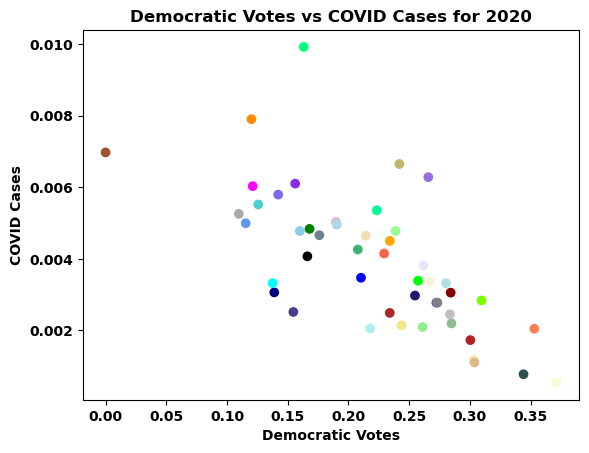

In [37]:
# Plotting Democratic Votes for 2020
x = []
y = []
for s in states:
    x.append(votes_norm[2020][s]['DEMOCRAT'])
    y.append(cases_norm[2020][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Democratic Votes vs COVID Cases for 2020")
plt.xlabel("Democratic Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

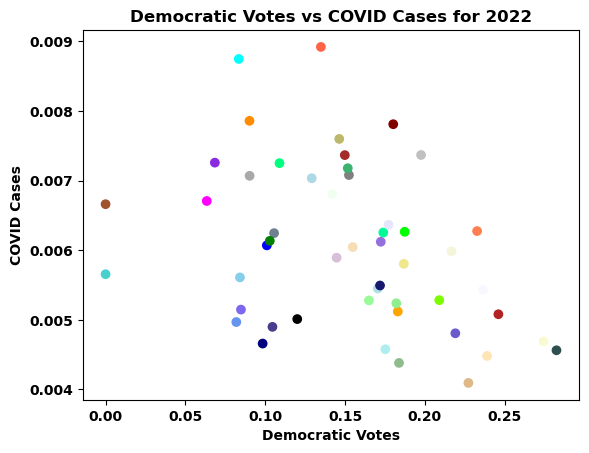

In [38]:
# Plotting Democratic Votes for 2022
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['DEMOCRAT'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Democratic Votes vs COVID Cases for 2022")
plt.xlabel("Democratic Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

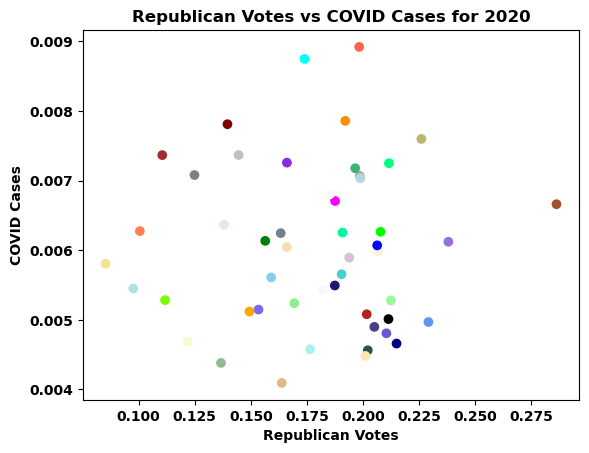

In [39]:
# Plotting Republican Votes for 2020
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['REPUBLICAN'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Republican Votes vs COVID Cases for 2020")
plt.xlabel("Republican Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

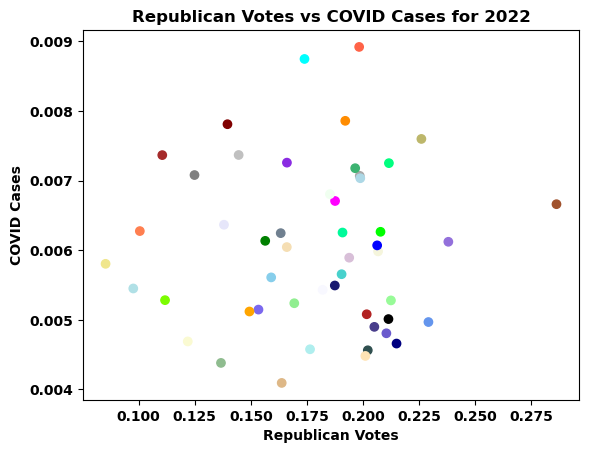

In [40]:
# Plotting Republican Votes for 2022
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['REPUBLICAN'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Republican Votes vs COVID Cases for 2022")
plt.xlabel("Republican Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

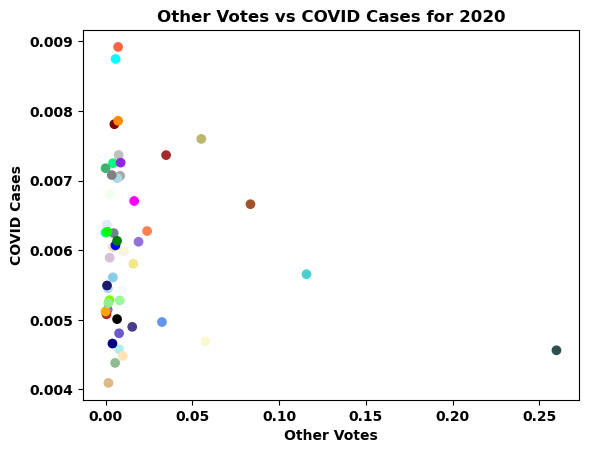

In [41]:
# Plotting Republican Votes for 2020
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['OTHER'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Other Votes vs COVID Cases for 2020")
plt.xlabel("Other Votes")
plt.ylabel("COVID Cases")

# Notes
- South Dakota has no Democratic party for its House of Representatives elections (only Republican and Libertarian)
    - Removing it means that 3 becomes the optimal clustering method

# Functions For Plotting

In [37]:
# Returns an DataFrame with State, Votes, and Cases for specified years and party
# All functions below will use the DataFrame returned from this
# function as it sets up the correct column names for the rest of the functions
def plot_df_specific(votes, cases, votes_year, cases_year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])

    return ret_df

In [38]:
# Simple L2 Norm for distance measure
def distance(l1, l2):
    return np.sqrt(np.sum([(np.asarray(l1)-np.asarray(l2))**2]))

# kmeans algo developed in HW 3, changed to fit this problem,
# more specifically, to be used with the DataFrame from
# plot_df_specific(...) as it has the correct column names
def kmeans(df, k=4, tol=0.01): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    # initialize with random centroids
    choice_centroids = np.random.choice(range(len(df)), k, replace=False)
    centroids = []
    for i in range(len(choice_centroids)):
        row = df.iloc[choice_centroids[i], :]
        centroids.append([row.Votes, row.Cases])
        
    # start with an empty cluster array
    clusters = np.array([-1]*len(df))
    
    # iteration counter for fun and testing
    iter_count = 0
    
    # set up variables for the convergence check
    current_error = 0
    new_error = np.inf

    # iterate until there is little difference within the square error
    while(np.abs(current_error - new_error) > tol):
        # update the error of our current iteration
        current_error = new_error
        
        # assign to clusters
        for i in range(len(clusters)):
            row = df.iloc[i, :]
            input_list = [row.Votes, row.Cases]
            
            dists = [distance(input_list, cent) for cent in centroids]
        
            assignment = dists.index(min(dists))
            clusters[i] = assignment

        # update centroids
        for j in range(k):
            # print(len(df[clusters==j]))
            centroids[j] = [np.sum(df[clusters==j].Votes)/len(df[clusters==j]), \
                            np.sum(df[clusters==j].Cases)/len(df[clusters==j])]

        # calculate the error for each cluster
        clust_error = [0] * len(clusters)
        
        for i in range(len(clusters)):
            row = df.iloc[i, :]
            input_list = [row.Votes, row.Cases]
            clust_error[clusters[i]] += distance(centroids[clusters[i]], \
                                                 input_list) ** 2
            
        # set new error (average error of all the clusters)
        new_error = np.mean(clust_error)
        
        
    
    meanerror = new_error
    return centroids, clusters, meanerror

In [39]:
# Funtion to make an elbowplot of, slightly optimized
# by the n_runs variable
def elbow_plot(data, ks, title="Elbow plot", n_runs=10):
    inertias = []
    for k in ks:
        # repeat the kmeans algo n_runs times for each k
        # to get a more accurate measure
        k_inertias = []
        for i in range(n_runs):
            _, _, meanerror = kmeans(data, k)
            k_inertias.append(meanerror)
        # only plot the best meanerror found for the value of k
        inertias.append(np.min(k_inertias))
    
    # plot
    plt.scatter(ks, inertias)
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("Mean Error")

In [40]:
# Function to plot a specific cluster on the data
def plot_cluster_specific(data, clusters, colors=['b','g', 'r'], k=3):
    assert(len(colors) >= k)
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[clusters[i]])

    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return clusters

In [41]:
# Plotting data after (default) 20 runs of the kmeans algorithms
# to get a more optimized result
def plot_data_optimized(data, colors=['b','g', 'r'], k=3, n_runs=20):
    assert(len(colors) >= k)
    all_runs = []
    all_means = []

    # run the kmeans algo n_runs times and record results
    for i in range(n_runs):
        _, clusters, meanerror = kmeans(data, k)
        all_runs.append(clusters)
        all_means.append(meanerror)
        
    # select the best cluster assignment
    best_cluster = all_runs[all_means.index(np.min(all_means))]

    # make the color map
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[best_cluster[i]])

    # plot with the new color assignments
    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return best_cluster

In [42]:
def linear_regression_graph(data, x_max=0.8):
    # plug data into the linear regression equation
    lrm = LinReg(data["Votes"].values, data["Cases"].values)

    # make a line and predictions from the line
    line = np.arange(0, x_max, 0.05)
    predictions = (line * lrm.slope) + lrm.intercept

    # plot the data along with the linear regression line
    plt.scatter(data["Votes"], data["Cases"])
    plt.plot(line, predictions)
    return lrm.rvalue

In [43]:
# I have never used GeoPandas before, so I had to look up how to color states
# This was adapted from the tutorial at:
#  https://jcutrer.com/python/learn-geopandas-plotting-usmaps
    #  Geopandas repo where the map file is:
    #  git clone https://github.com/joncutrer/geopandas-tutorial.git
# Only maps 4 clusters as that is the optimal number of clusters for this data
def make_map(clusters, colors, title="Map"):
    cluster_list = list(zip(states, clusters))
    clust0 = [i[0] for i in cluster_list if i[1] == 0]
    clust1 = [i[0] for i in cluster_list if i[1] == 1]
    clust2 = [i[0] for i in cluster_list if i[1] == 2]
    clust3 = [i[0] for i in cluster_list if i[1] == 3]

    # Read in the file containing the state boundary information
    states_gpd = gpd.read_file('./geopandas-tutorial/data/usa-states-census-2014.shp')

    # Use the Mercator projection
    states_gpd = states_gpd.to_crs("EPSG:3395")

    # Color some states, identified by post office abbreviations
    cluster0 = states_gpd[states_gpd['STUSPS'].isin(clust0)]
    cluster1 = states_gpd[states_gpd['STUSPS'].isin(clust1)]
    cluster2 = states_gpd[states_gpd['STUSPS'].isin(clust2)]
    cluster3 = states_gpd[states_gpd['STUSPS'].isin(clust3)]

    ax_state_bounds = states_gpd.boundary.plot(figsize=(18, 12), color="Black")
    states_gpd.plot(ax=ax_state_bounds, color="Gray")
    cluster0.plot(ax=ax_state_bounds, color=colors[0])
    cluster1.plot(ax=ax_state_bounds, color=colors[1])
    cluster2.plot(ax=ax_state_bounds, color=colors[2])
    cluster3.plot(ax=ax_state_bounds, color=colors[3])

    # Turn off axes
    ax_state_bounds.set_axis_off()

    # Add a title
    ax_state_bounds.set_title(title, fontsize=40, )

    # Work with the image at this point as a "figure"
    fig = ax_state_bounds.get_figure()
    fig.tight_layout()  # Get rid of extra white space at edges

In [55]:
# Adding in Alaska and Hawaii was a little more work, but I found a tutorial and adaped it to my needs
# Code adaped from:
# https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6
def make_map_AK_HI(clusters, colors, title="Map"):
    gdf = gpd.read_file('./cb_2018_us_state_500k')
    states_df = pd.DataFrame({'state': states, 'cluster': clusters})
    gdf = gdf.merge(states_df,left_on='STUSPS',right_on='state')
    # create "visframe" as a re-projected gdf using EPSG 2163
    visframe = gdf.to_crs({'init':'epsg:2163'})

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(18, 14))
    # remove the axis box around the vis
    ax.axis('off')

    # set the font for the visualization to Helvetica
    hfont = {'fontname':'Helvetica'}

    # add a title and annotation
    ax.set_title(title, fontdict={'fontsize': '42', 'fontweight' : '1'})

    # create map
    # Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
    # print(list(visframe.itertuples()))
    for row in visframe.itertuples():
        # print(row)
        if row.state not in ['AK','HI']:
            vf = visframe[visframe.state==row.state]
            # print(gdf[gdf.state_x==row.state_x][0:1])
            c = colors[gdf[gdf.state==row.state][0:1].cluster.item()]
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    # polygon to clip western islands
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf.state=='AK']
    alaska_gdf.clip(polygon).plot(color=colors[gdf[gdf.state=='AK'][0:1].cluster.item()], linewidth=0.8,ax=akax, edgecolor='0.8')


    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    # polygon to clip western islands
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf.state=='HI']
    hawaii_gdf.clip(hipolygon).plot(color=colors[gdf[gdf.state=='AK'][0:1].cluster.item()], linewidth=0.8,ax=hiax, edgecolor='0.8')

In [45]:
gdf = gpd.read_file('./cb_2018_us_state_500k')
print(gdf.columns)
gdf.head()

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [46]:
states_df = pd.DataFrame({'state': states, 'cluster': [3, 2, 2, 3, 0, 2, 0, 0, 2, 2, 0, 3, 0, 3, 2, 2, 3, 3, 0, 0, 0, 2, 2, 3, 3, 2, 3, 2, 2, 0, 0, 0, 2, 3, 2, 3, 0, 2, 0, 2, 1, 3, 2, 3, 0, 2, 0, 3, 2, 3]})
gdf = gdf.merge(states_df,left_on='STUSPS',right_on='state')
# colors = ['r', 'g', 'b', 'k']
colors = ['navy', 'lightblue', 'blue', 'dodgerblue']
gdf.head()
print(gdf.columns)
# gdf.rename(columns={"state_x: state"}, inplace=True)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'state', 'cluster'],
      dtype='object')


In [47]:
colors = ['navy', 'lightblue', 'blue', 'dodgerblue']

In [113]:
print(gdf[gdf.state_x=='AK'].cluster_x.values[0])
print(type(gdf[gdf.state_x=='AK'].cluster_x))

2
<class 'pandas.core.series.Series'>


c:\Users\meowm\anaconda3\envs\GPD\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

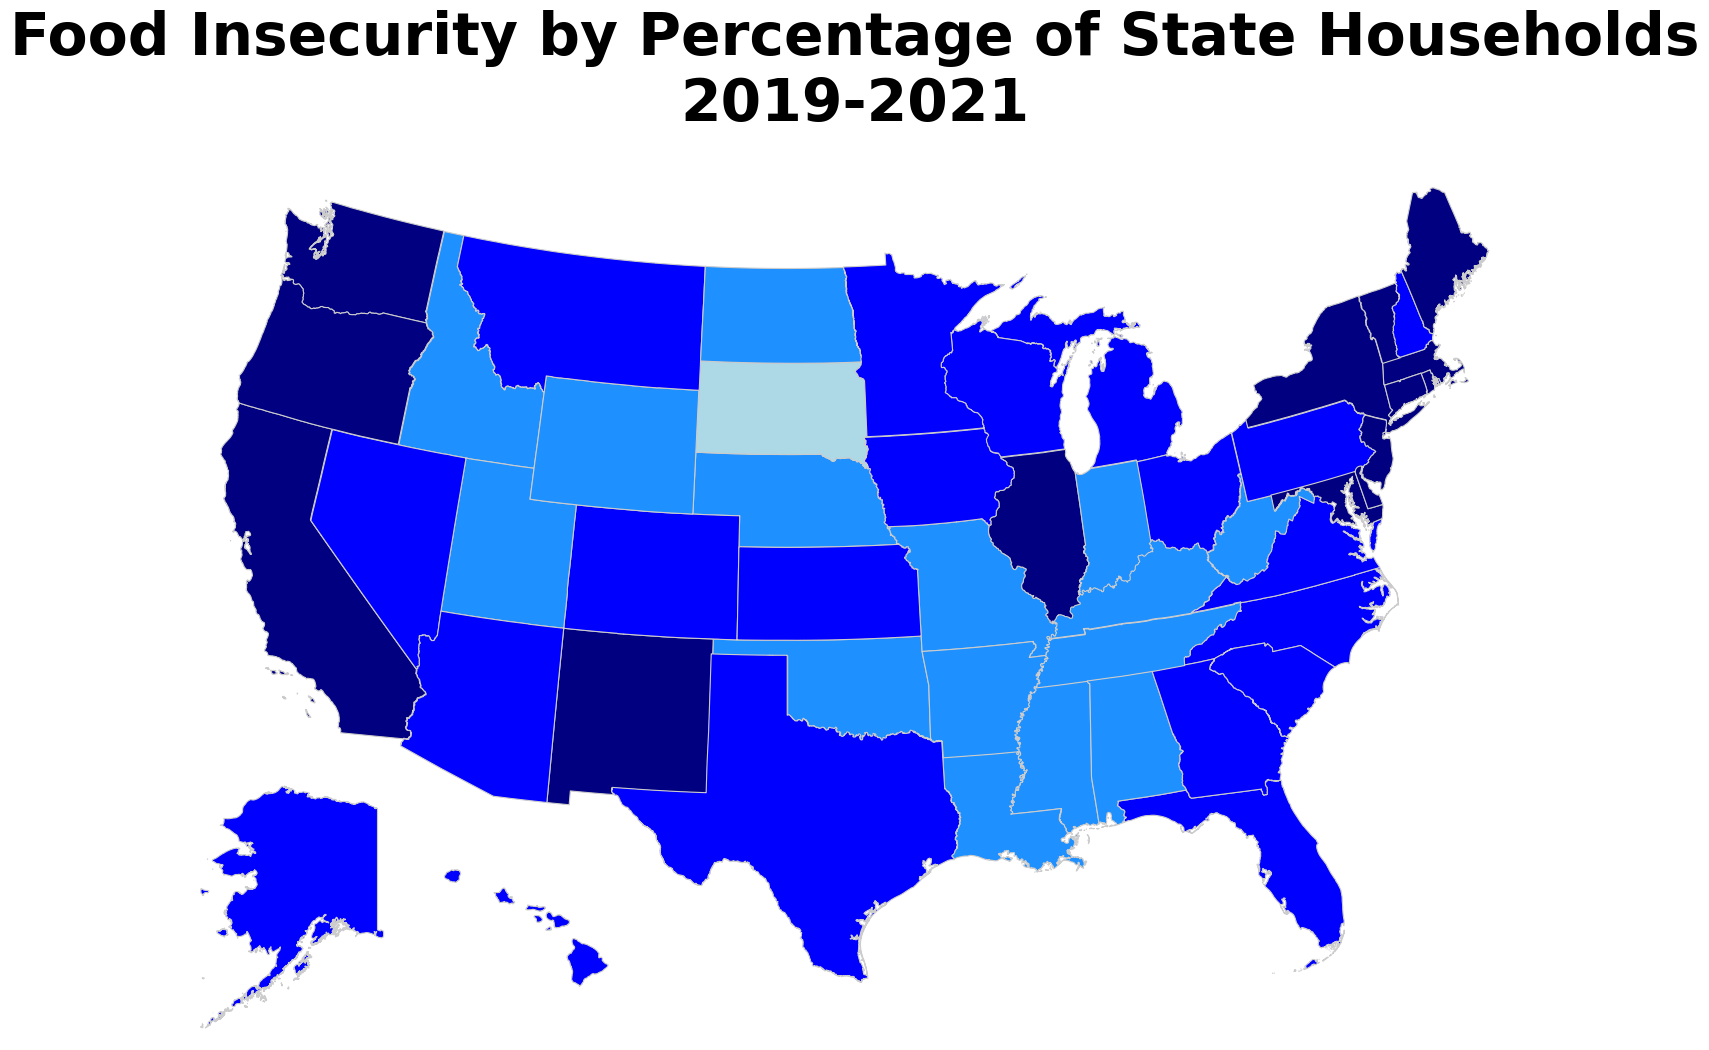

In [119]:
from shapely.geometry import Polygon
# **************************
# set the value column that will be visualised
variable = 'pct_food_insecure'

# create "visframe" as a re-projected gdf using EPSG 2163
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Food Insecurity by Percentage of State Households\n2019-2021', fontdict={'fontsize': '42', 'fontweight' : '1'})

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
# print(list(visframe.itertuples()))
for row in visframe.itertuples():
    # print(row)
    if row.state_x not in ['AK','HI']:
        vf = visframe[visframe.state_x==row.state_x]
        # print(gdf[gdf.state_x==row.state_x][0:1])
        c = colors[gdf[gdf.state_x==row.state_x][0:1].cluster_x.item()]
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.state_x=='AK']
alaska_gdf.clip(polygon).plot(color=colors[gdf[gdf.state_x=='AK'][0:1].cluster_x.item()], linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.state_x=='HI']
hawaii_gdf.clip(hipolygon).plot(color=colors[gdf[gdf.state_x=='AK'][0:1].cluster_x.item()], linewidth=0.8,ax=hiax, edgecolor='0.8')

# Notes on Data
House: Bad: Votes, **good: votes_prop**  
- votes for a party in a state and year divided by the total votes in that state and year. 

COVID: bad: cases_by_year_state, **good: cases_norm**  
- total adult and pediatric cases for a state divided by that state's 2020 Census population  

# Democrat 2020 House, 2020 COVID

C:\Users\meowm\AppData\Local\Temp\ipykernel_34452\990590549.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])


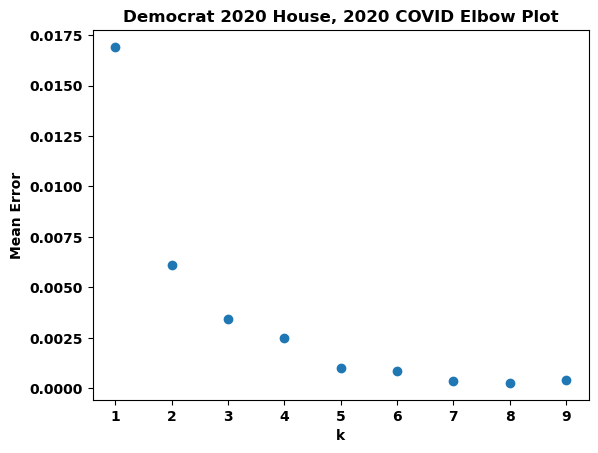

In [48]:
dem_h_2020_c_2020 = plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'DEMOCRAT')
elbow_plot(dem_h_2020_c_2020, list(range(1, 10)), "Democrat 2020 House, 2020 COVID Elbow Plot")

r-squared value of: 42.47982118664223%


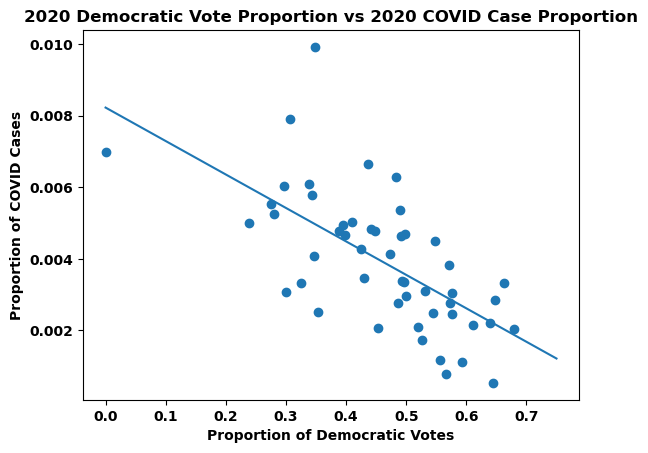

In [49]:
r_val = linear_regression_graph(dem_h_2020_c_2020, 0.8)
plt.title("2020 Democratic Vote Proportion vs 2020 COVID Case Proportion")
plt.xlabel("Proportion of Democratic Votes")
plt.ylabel("Proportion of COVID Cases")
print(f"r-squared value of: {r_val ** 2 * 100}%")

[3 2 2 3 0 2 0 0 2 2 0 3 0 3 2 2 3 3 0 0 0 2 2 3 3 2 3 2 2 0 0 0 2 3 2 3 0
 2 0 2 1 3 2 3 0 2 0 3 2 3]


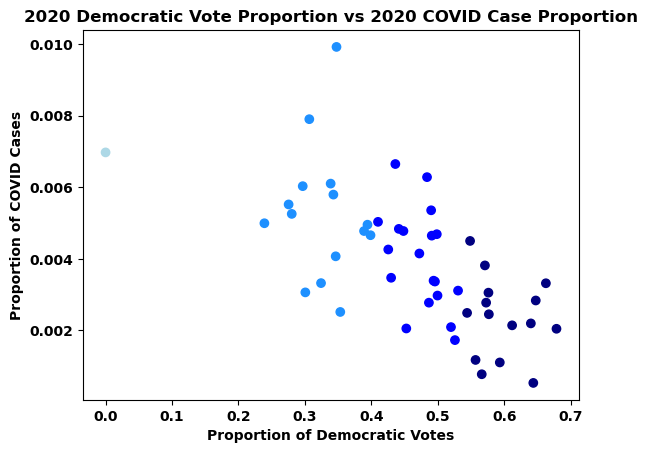

In [50]:
np.random.seed(2020)
# best_cluster = plot_data_optimized(dem_h_2020_c_2020, ['r', 'g', 'b', 'gray'], 4, 50)
best_cluster = plot_data_optimized(dem_h_2020_c_2020, ['navy', 'lightblue', 'blue', 'dodgerblue'], 4, 50)
print(best_cluster)
plt.title("2020 Democratic Vote Proportion vs 2020 COVID Case Proportion")
plt.xlabel("Proportion of Democratic Votes")
plt.ylabel("Proportion of COVID Cases")
# Seeded environment, so use the colors in the correct way

# best_colors = ['r', 'g', 'b', 'gray']
best_colors = ['navy', 'lightblue', 'blue', 'dodgerblue']

In [51]:
print(sorted(list(zip(states, best_cluster)), key=lambda x: x[1]))
cluster_list = list(zip(states, best_cluster))
clust0 = [i[0] for i in cluster_list if i[1] == 0]
clust1 = [i[0] for i in cluster_list if i[1] == 1]
clust2 = [i[0] for i in cluster_list if i[1] == 2]
clust3 = [i[0] for i in cluster_list if i[1] == 3]
print(len(clust0))
print(len(clust1))
print(len(clust2))
print(len(clust3))

[('CA', 0), ('CT', 0), ('DE', 0), ('HI', 0), ('IL', 0), ('ME', 0), ('MD', 0), ('MA', 0), ('NJ', 0), ('NM', 0), ('NY', 0), ('OR', 0), ('RI', 0), ('VT', 0), ('WA', 0), ('SD', 1), ('AK', 2), ('AZ', 2), ('CO', 2), ('FL', 2), ('GA', 2), ('IA', 2), ('KS', 2), ('MI', 2), ('MN', 2), ('MT', 2), ('NV', 2), ('NH', 2), ('NC', 2), ('OH', 2), ('PA', 2), ('SC', 2), ('TX', 2), ('VA', 2), ('WI', 2), ('AL', 3), ('AR', 3), ('ID', 3), ('IN', 3), ('KY', 3), ('LA', 3), ('MS', 3), ('MO', 3), ('NE', 3), ('ND', 3), ('OK', 3), ('TN', 3), ('UT', 3), ('WV', 3), ('WY', 3)]
15
1
19
15


In [52]:
s = 'TX'
print(votes_prop[2020][s])
print(cases_norm[2020][s])

{'DEMOCRAT': 0.441395175932558, 'REPUBLICAN': 0.534244799671451, 'OTHER': 0.024360024395990994}
0.00483865350763351


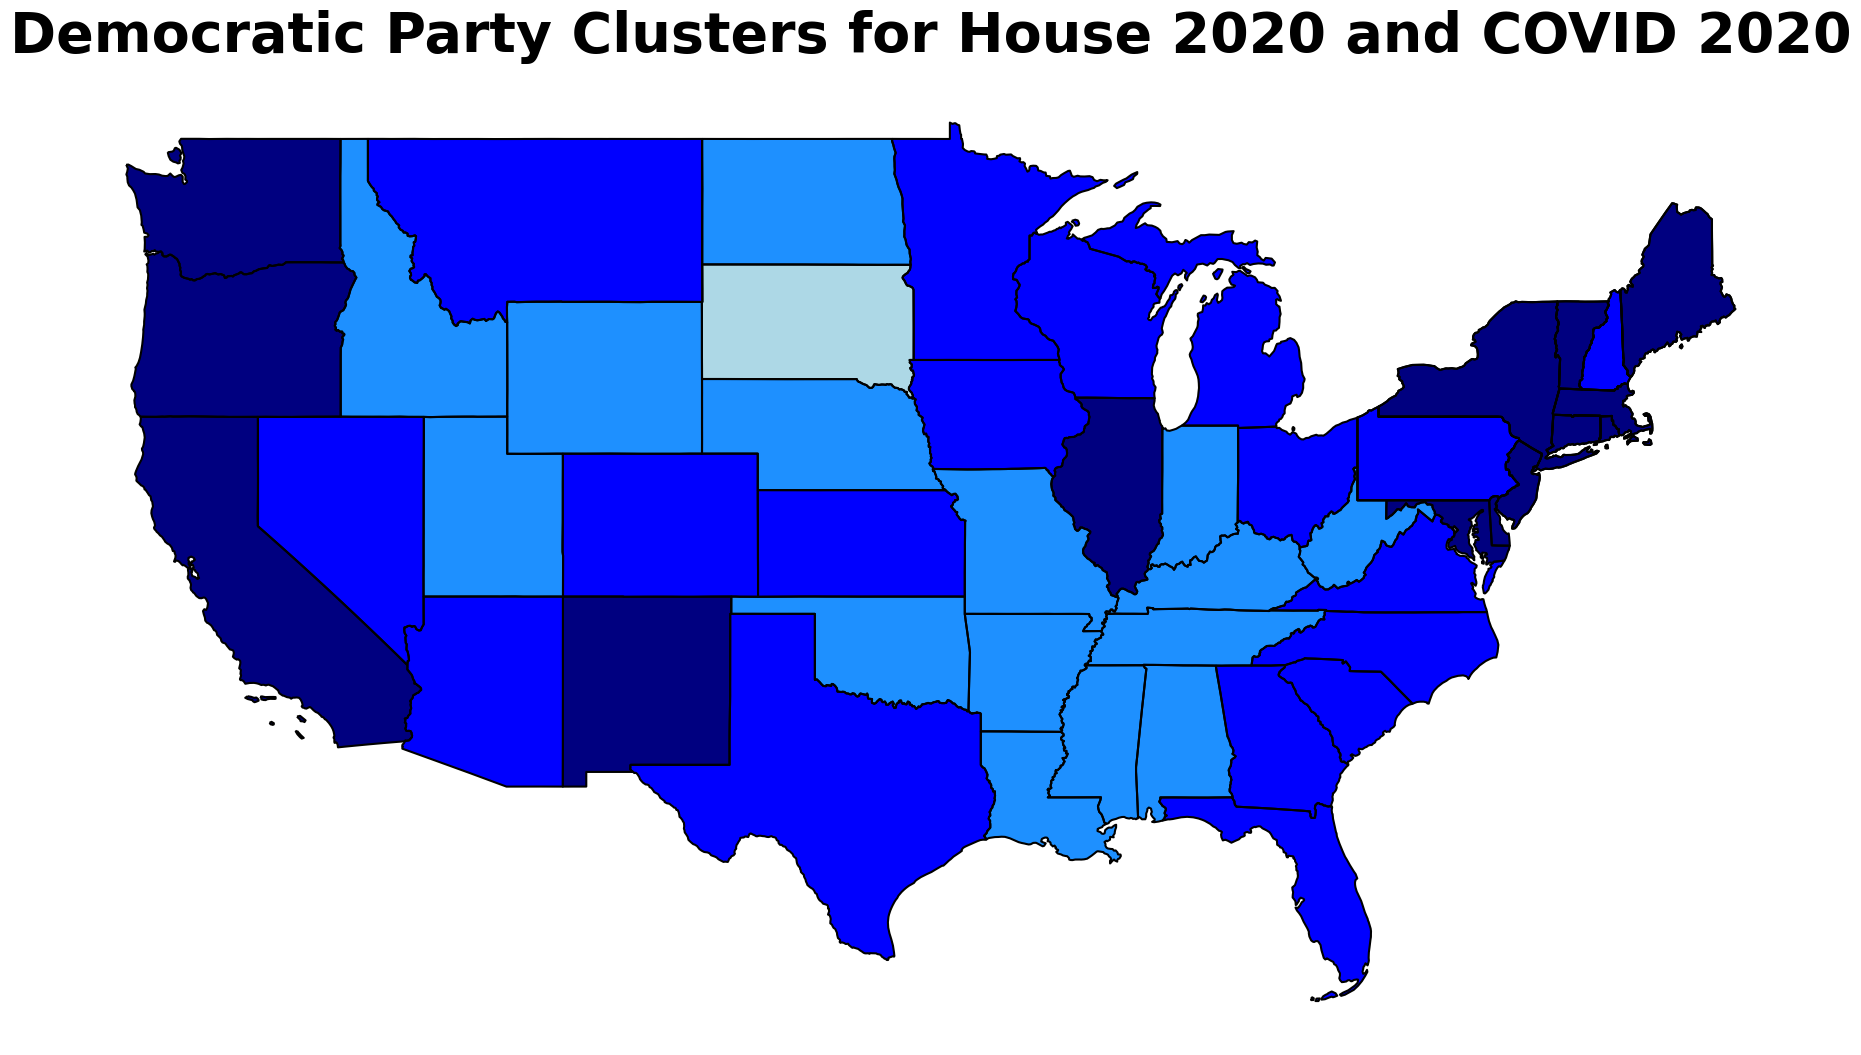

In [53]:
make_map(best_cluster, best_colors, "Democratic Party Clusters for House 2020 and COVID 2020")

c:\Users\meowm\anaconda3\envs\GPD\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


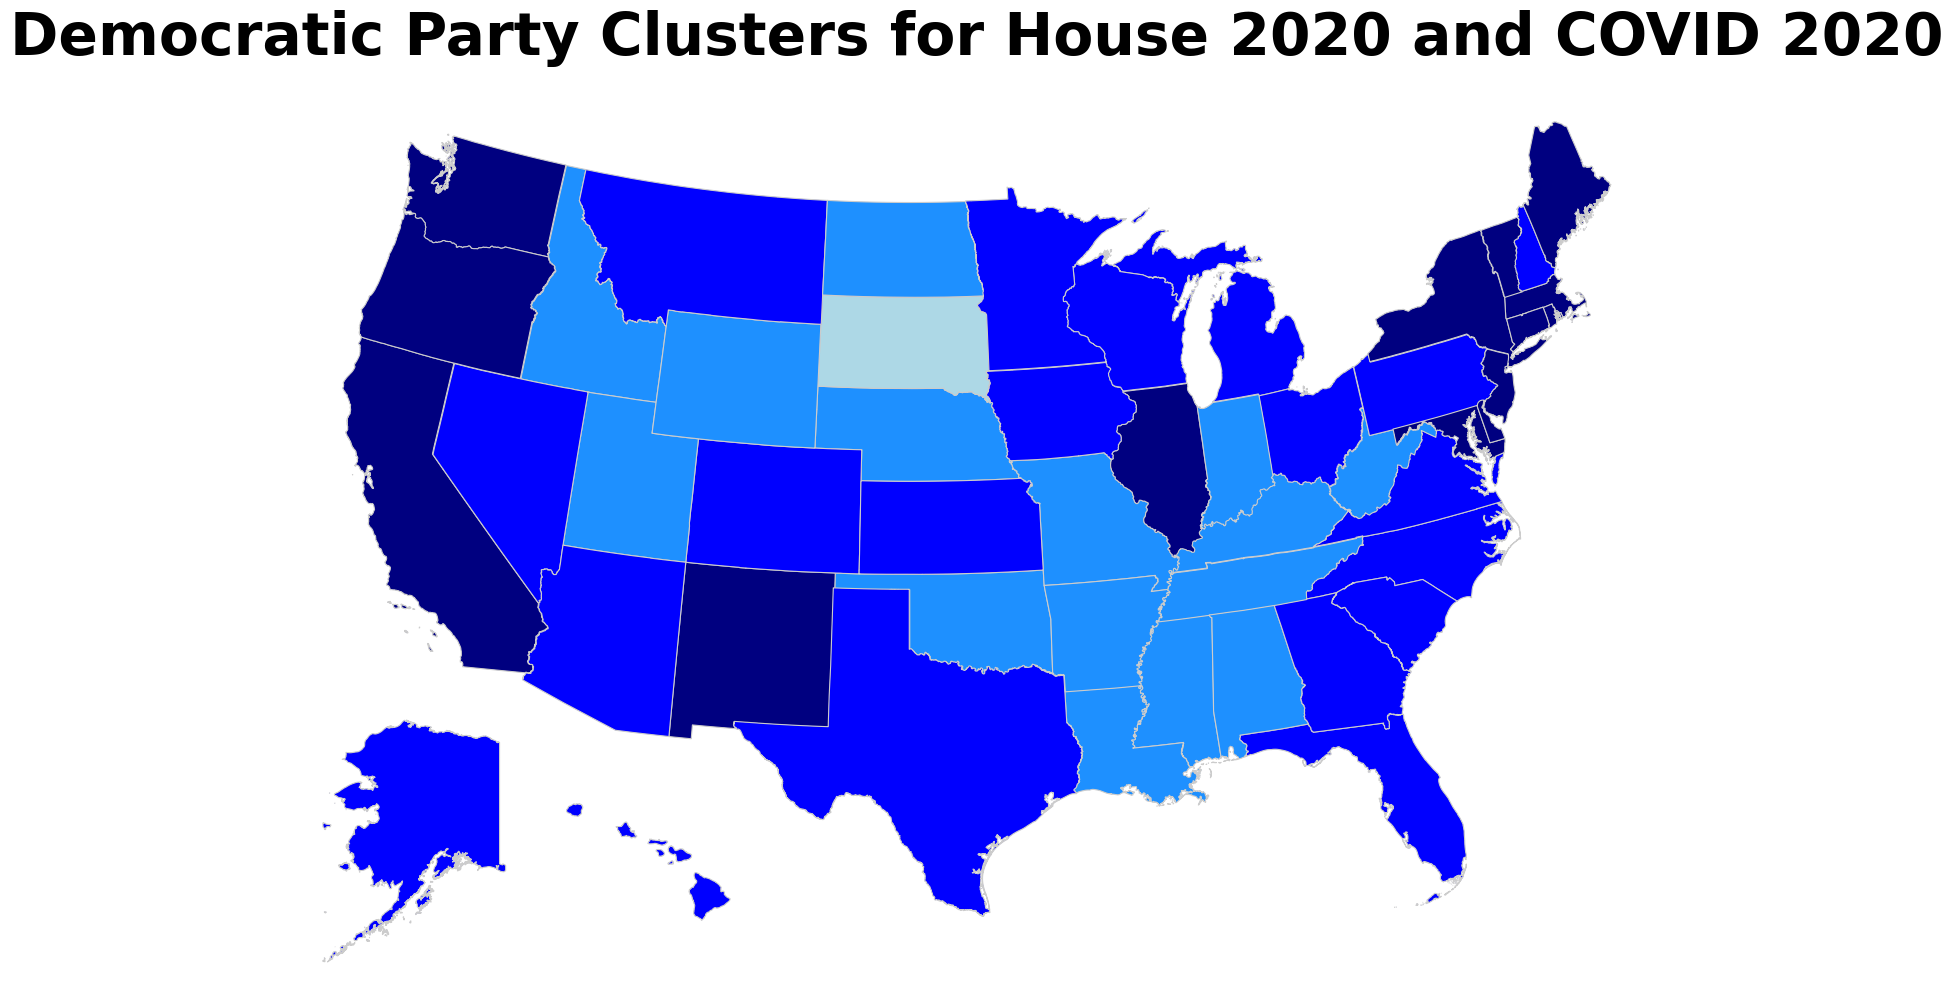

In [56]:
make_map_AK_HI(best_cluster, best_colors, "Democratic Party Clusters for House 2020 and COVID 2020")

# Republican 2020, 2020

C:\Users\meowm\AppData\Local\Temp\ipykernel_34452\990590549.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])


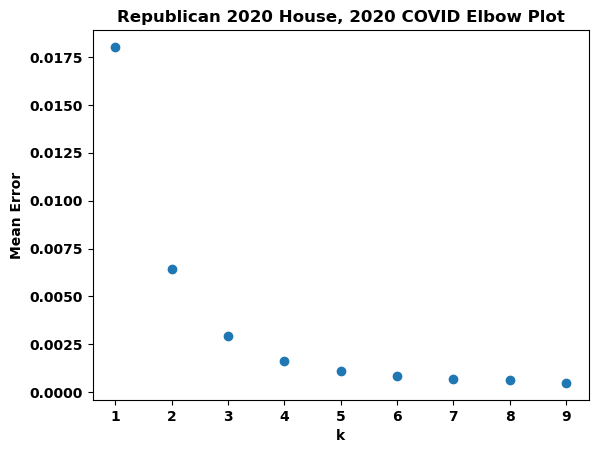

In [58]:
rep_h_2020_c_2020 = plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'REPUBLICAN')
elbow_plot(rep_h_2020_c_2020, list(range(1, 10)), "Republican 2020 House, 2020 COVID Elbow Plot")

r-squared value of: 46.63181859632965%


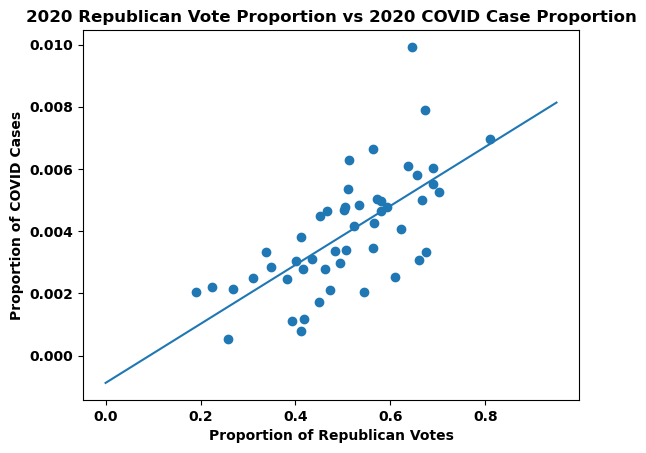

In [59]:
r_val = linear_regression_graph(rep_h_2020_c_2020, 1)
plt.title("2020 Republican Vote Proportion vs 2020 COVID Case Proportion")
plt.xlabel("Proportion of Republican Votes")
plt.ylabel("Proportion of COVID Cases")
print(f"r-squared value of: {r_val ** 2 * 100}%")

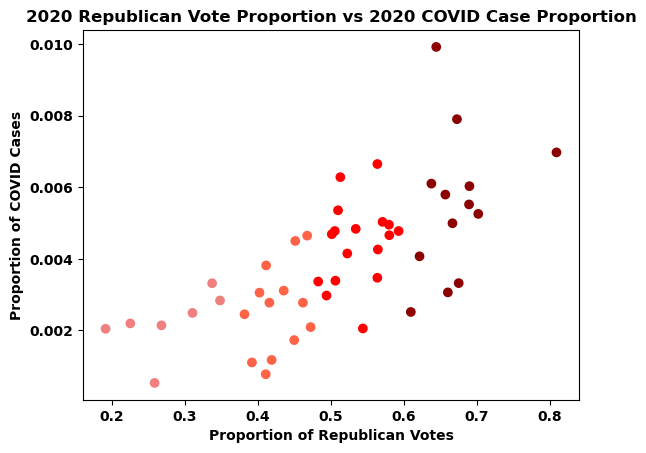

In [60]:
np.random.seed(2020)
best_cluster = plot_data_optimized(rep_h_2020_c_2020, ['red', 'tomato', 'darkred', 'lightcoral'], 4, 50)
plt.title("2020 Republican Vote Proportion vs 2020 COVID Case Proportion")
plt.xlabel("Proportion of Republican Votes")
plt.ylabel("Proportion of COVID Cases")
# Because this is a seeded environment, I am going to use the color arrangments below to line up the colors in the map below
# ['r', 'g', 'b', 'gray']
# ['blue', 'dodgerblue', 'navy', 'lightblue']
# best_colors = ['r', 'g', 'b', 'gray']
# best_colors = ['blue', 'dodgerblue', 'navy', 'lightblue']
best_colors = ['red', 'tomato', 'darkred', 'lightcoral']

In [61]:
s = 'AZ'
print(votes_prop[2020][s])
print(cases_norm[2020][s])

{'DEMOCRAT': 0.49853514833172136, 'REPUBLICAN': 0.5013681638088163, 'OTHER': 9.668785946236043e-05}
0.004690343371224674


In [62]:
print(sorted(list(zip(states, best_cluster)), key=lambda x: x[1]))
cluster_list = list(zip(states, best_cluster))
clust0 = [i[0] for i in cluster_list if i[1] == 0]
clust1 = [i[0] for i in cluster_list if i[1] == 1]
clust2 = [i[0] for i in cluster_list if i[1] == 2]
clust3 = [i[0] for i in cluster_list if i[1] == 3]
print(len(clust0))
print(len(clust1))
print(len(clust2))
print(len(clust3))

[('AK', 0), ('AZ', 0), ('FL', 0), ('GA', 0), ('IN', 0), ('IA', 0), ('KS', 0), ('MI', 0), ('MO', 0), ('MT', 0), ('NC', 0), ('OH', 0), ('PA', 0), ('SC', 0), ('TN', 0), ('TX', 0), ('WI', 0), ('CO', 1), ('CT', 1), ('DE', 1), ('IL', 1), ('ME', 1), ('MN', 1), ('NV', 1), ('NH', 1), ('NJ', 1), ('NM', 1), ('OR', 1), ('VA', 1), ('WA', 1), ('AL', 2), ('AR', 2), ('ID', 2), ('KY', 2), ('LA', 2), ('MS', 2), ('NE', 2), ('ND', 2), ('OK', 2), ('SD', 2), ('UT', 2), ('WV', 2), ('WY', 2), ('CA', 3), ('HI', 3), ('MD', 3), ('MA', 3), ('NY', 3), ('RI', 3), ('VT', 3)]
17
13
13
7


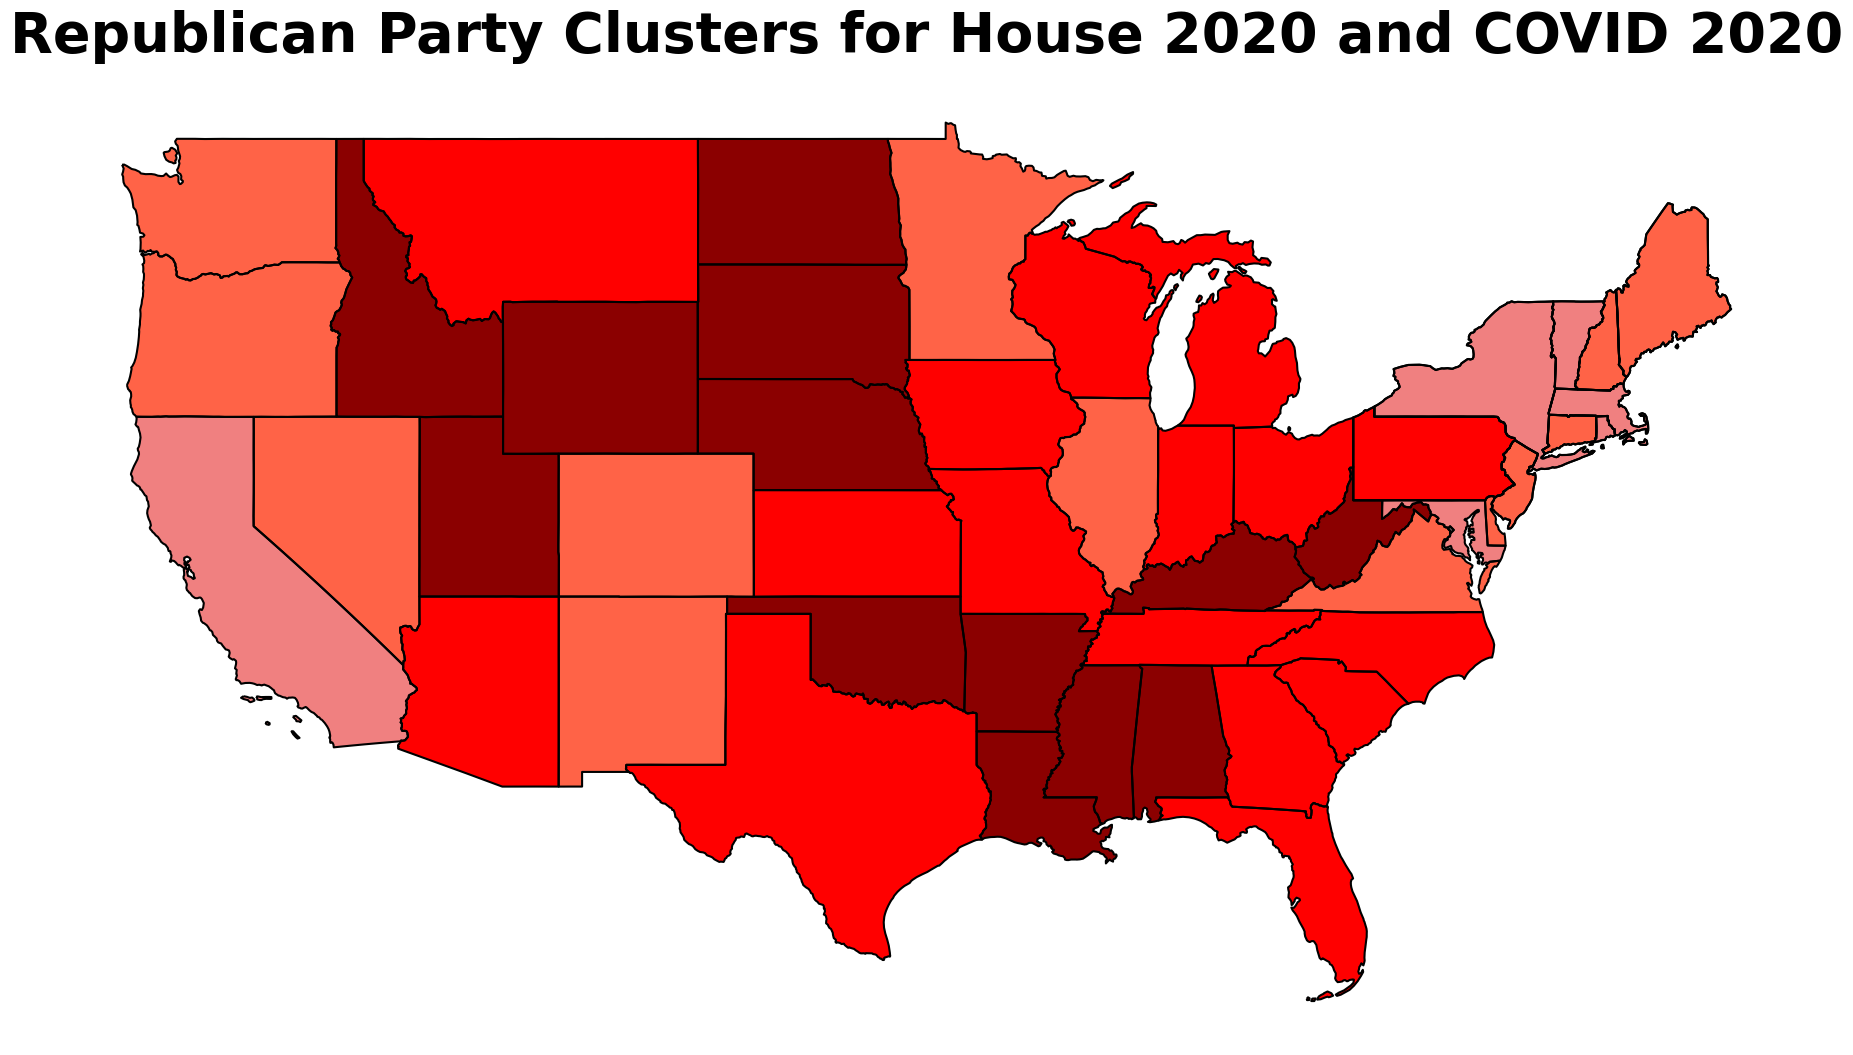

In [63]:
make_map(best_cluster, best_colors, "Republican Party Clusters for House 2020 and COVID 2020")

c:\Users\meowm\anaconda3\envs\GPD\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


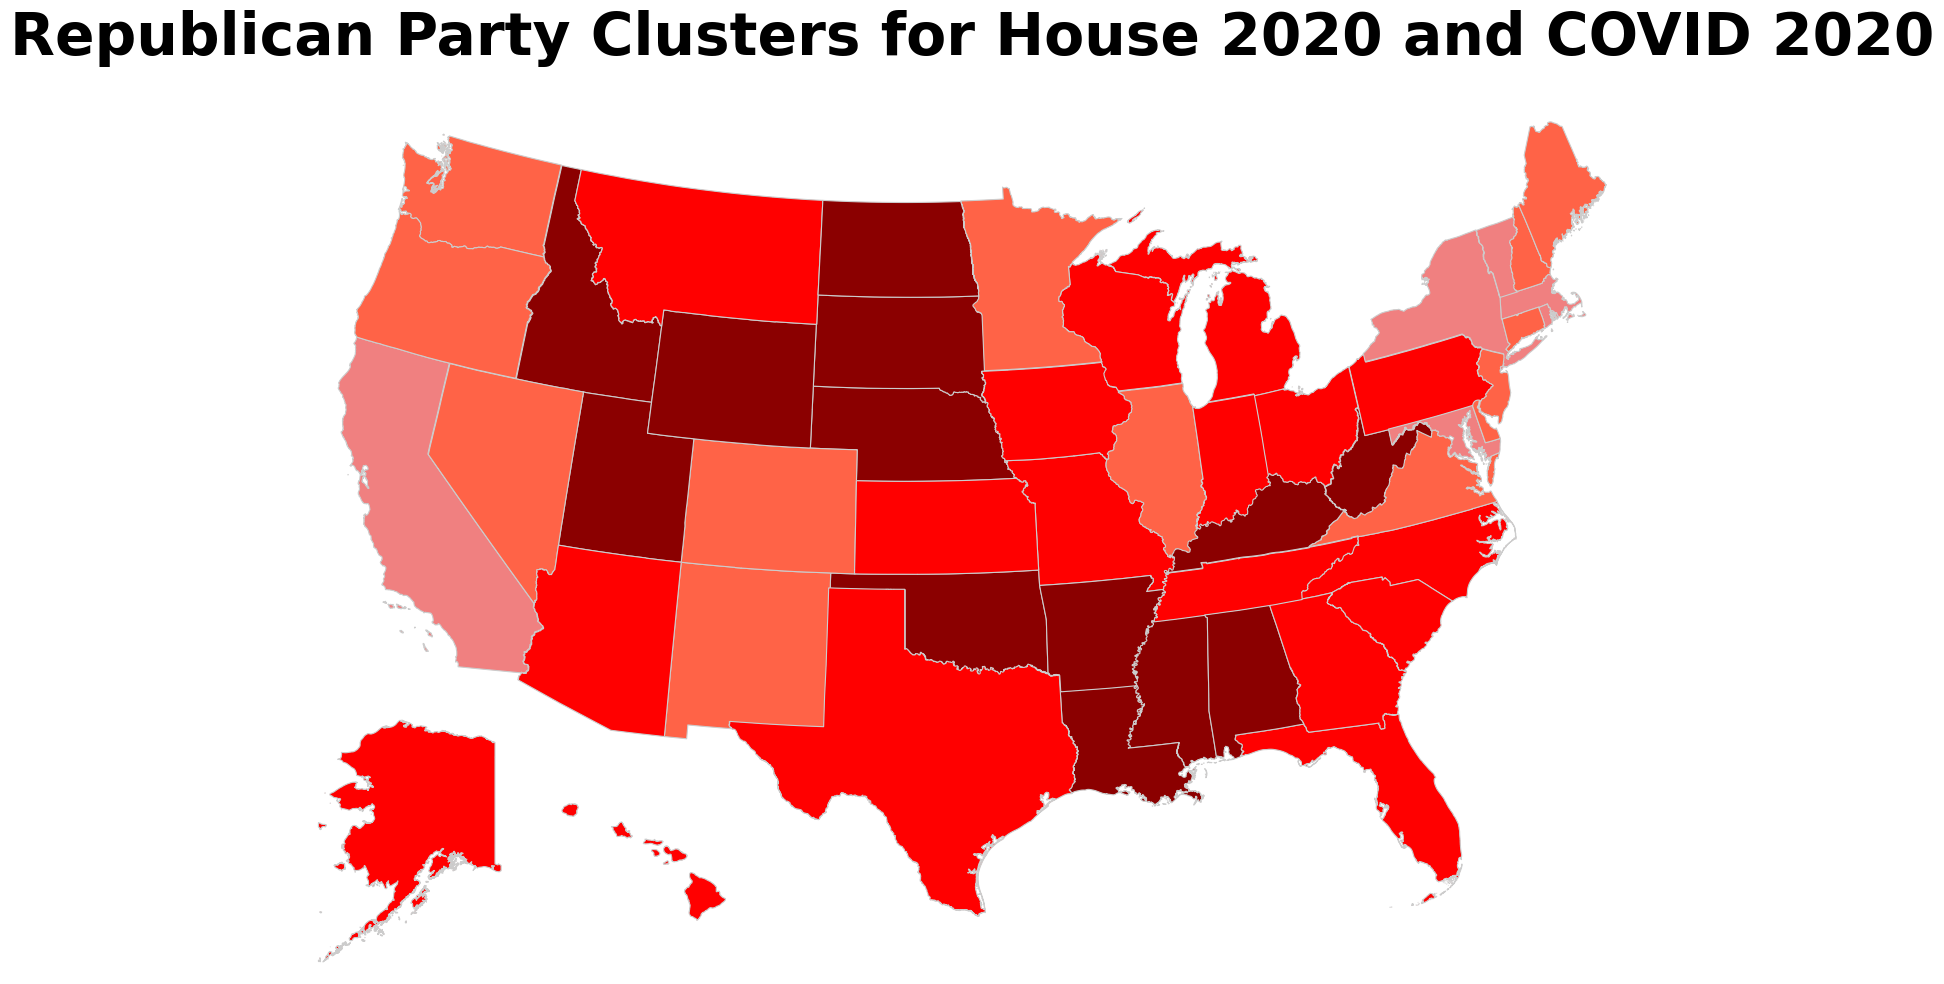

In [64]:
make_map_AK_HI(best_cluster, best_colors, "Republican Party Clusters for House 2020 and COVID 2020")

# Democrat 2022 House, 2022 COVID

C:\Users\meowm\AppData\Local\Temp\ipykernel_34452\990590549.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])


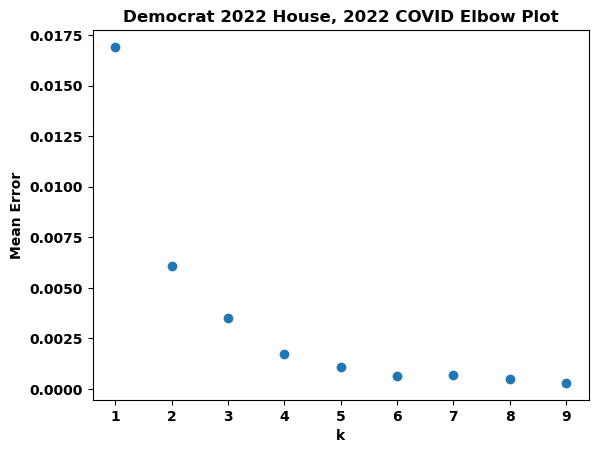

In [65]:
dem_h_2022_c_2022 = plot_df_specific(votes_prop, cases_norm, 2022, 2022, 'DEMOCRAT')
elbow_plot(dem_h_2020_c_2020, list(range(1, 10)), "Democrat 2022 House, 2022 COVID Elbow Plot")

r-squared value of: 4.9145173407455385%


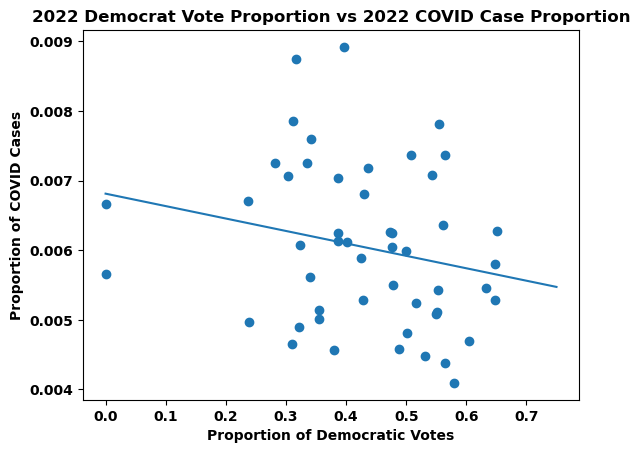

In [66]:
r_val = linear_regression_graph(dem_h_2022_c_2022, 0.8)
plt.title("2022 Democrat Vote Proportion vs 2022 COVID Case Proportion")
plt.xlabel("Proportion of Democratic Votes")
plt.ylabel("Proportion of COVID Cases")
print(f"r-squared value of: {r_val ** 2 * 100}%")

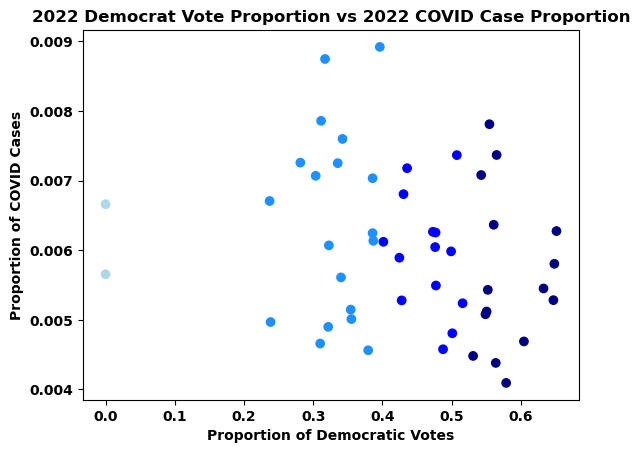

In [67]:
np.random.seed(2020)
# best_cluster = plot_data_optimized(dem_h_2022_c_2022, ['r', 'g', 'b', 'gray']['blue', 'lightblue', 'navy', 'dodgerblue'], 4, 50)
best_cluster = plot_data_optimized(dem_h_2022_c_2022, ['navy', 'lightblue', 'blue', 'dodgerblue'], 4, 50)
plt.title("2022 Democrat Vote Proportion vs 2022 COVID Case Proportion")
plt.xlabel("Proportion of Democratic Votes")
plt.ylabel("Proportion of COVID Cases")
# Because this is a seeded environment, I am going to use the color arrangments below to line up the colors in the map below
# best_colors = ['r', 'g', 'b', 'gray']['blue', 'lightblue', 'navy', 'dodgerblue']
best_colors = ['navy', 'lightblue', 'blue', 'dodgerblue']

In [68]:
s = 'CA'
print(votes_prop[2022][s])
print(cases_norm[2022][s])

{'DEMOCRAT': 0.6328363472432633, 'REPUBLICAN': 0.36219338521342354, 'OTHER': 0.004970267543313069}
0.005450421987857168


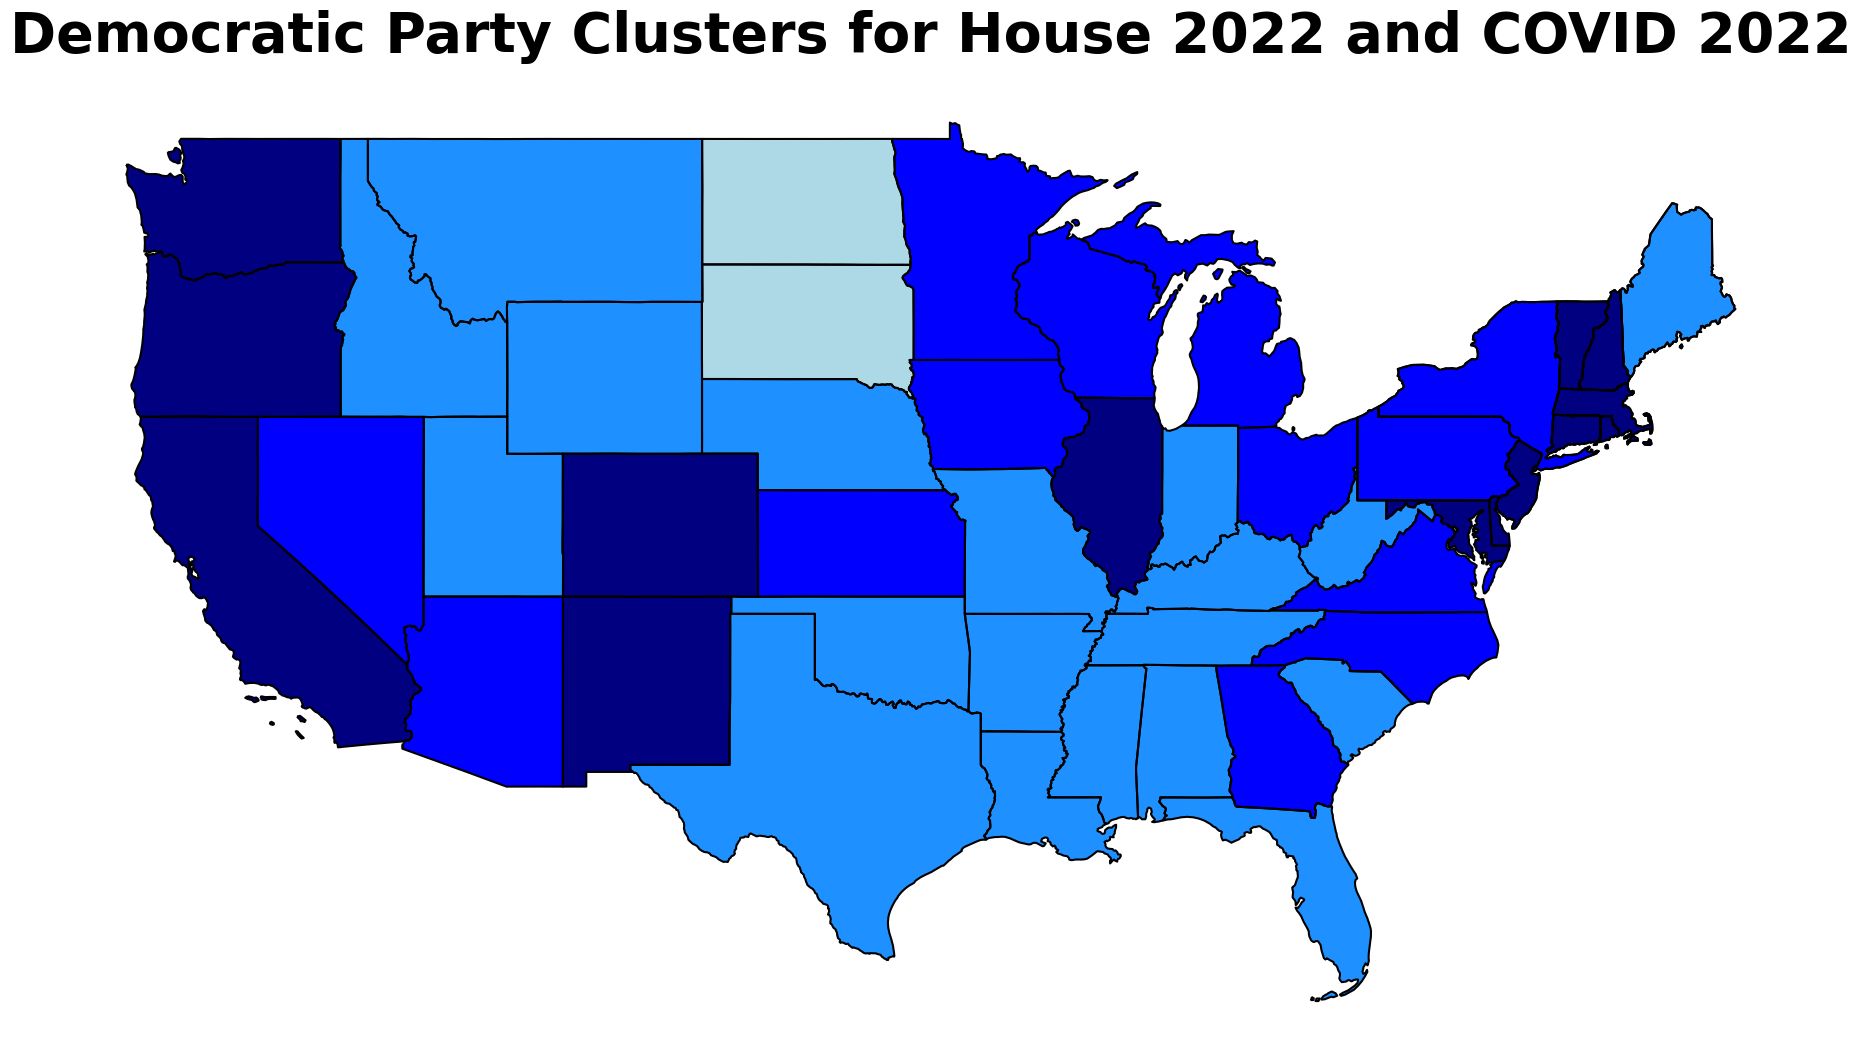

In [69]:
make_map(best_cluster, best_colors, "Democratic Party Clusters for House 2022 and COVID 2022")

c:\Users\meowm\anaconda3\envs\GPD\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


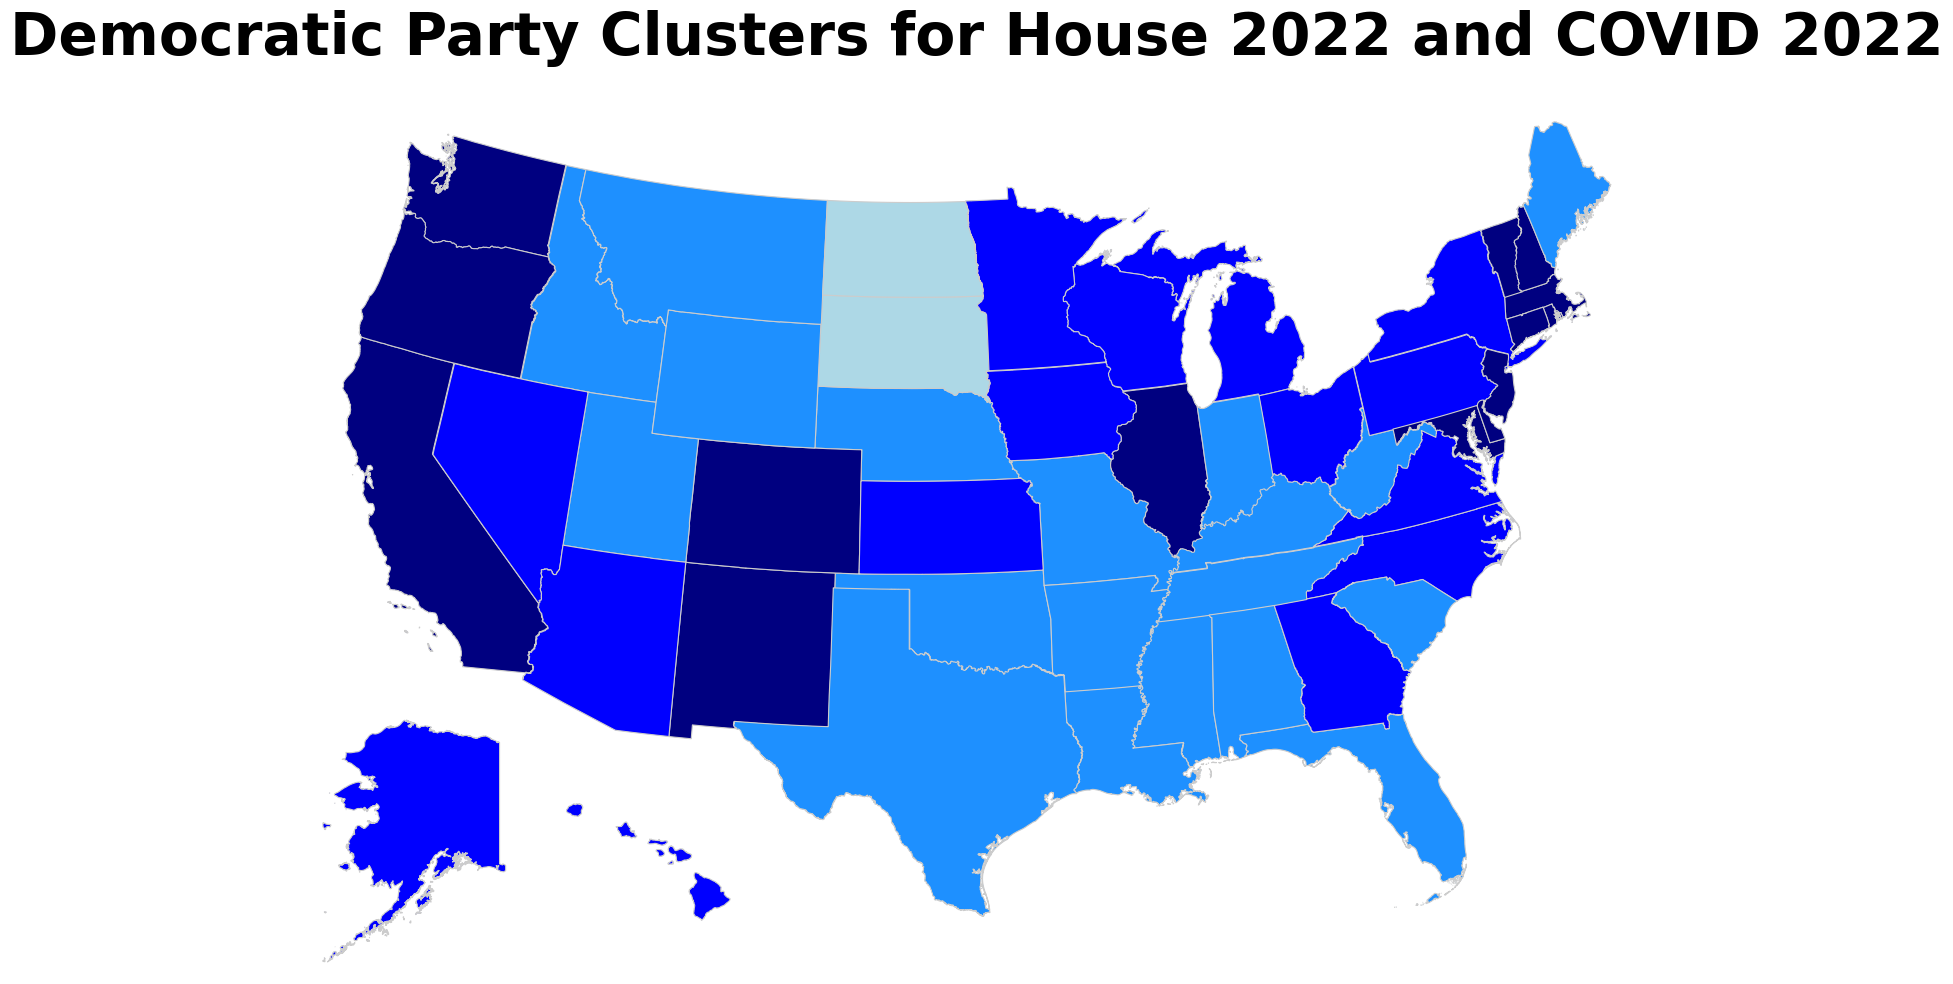

In [70]:
make_map_AK_HI(best_cluster, best_colors, "Democratic Party Clusters for House 2022 and COVID 2022")

# Republican 2022, 2022

C:\Users\meowm\AppData\Local\Temp\ipykernel_34452\990590549.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])


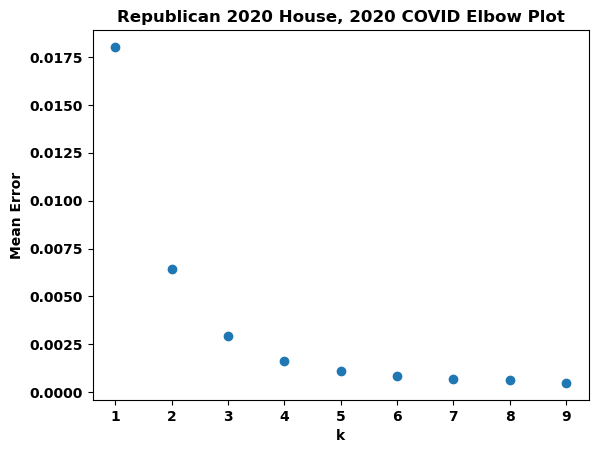

In [71]:
rep_h_2022_c_2022 = plot_df_specific(votes_prop, cases_norm, 2022, 2022, 'REPUBLICAN')
elbow_plot(rep_h_2020_c_2020, list(range(1, 10)), "Republican 2020 House, 2020 COVID Elbow Plot")

r-squared value of: 8.986418608412555%


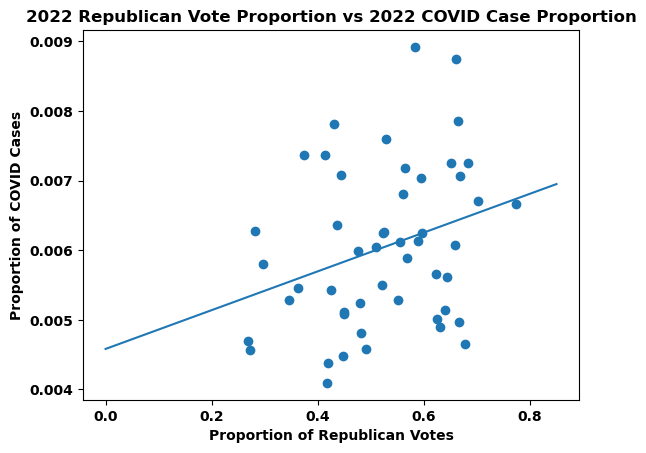

In [72]:
r_val = linear_regression_graph(rep_h_2022_c_2022, 0.9)
plt.title("2022 Republican Vote Proportion vs 2022 COVID Case Proportion")
plt.xlabel("Proportion of Republican Votes")
plt.ylabel("Proportion of COVID Cases")
print(f"r-squared value of: {r_val ** 2 * 100}%")

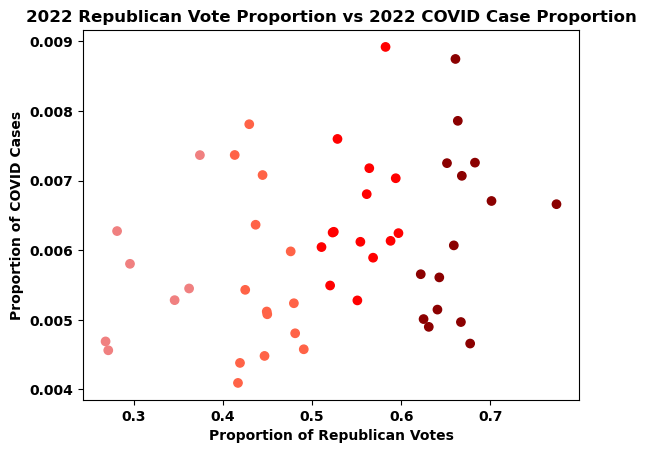

In [73]:
np.random.seed(2020)
# best_cluster = plot_data_optimized(rep_h_2022_c_2022, ['r', 'g', 'b', 'gray']['red', 'tomato', 'darkred', 'lightcoral'], 4, 50)
# best_cluster = plot_data_optimized(rep_h_2022_c_2022, ['red', 'tomato', 'darkred', 'lightcoral'], 4, 50)
best_cluster = plot_data_optimized(rep_h_2022_c_2022, ['lightcoral', 'red', 'tomato', 'darkred'], 4, 50)
plt.title("2022 Republican Vote Proportion vs 2022 COVID Case Proportion")
plt.xlabel("Proportion of Republican Votes")
plt.ylabel("Proportion of COVID Cases")
# Because this is a seeded environment, I am going to use the color arrangments below to line up the colors in the map below
# best_colors = ['r', 'g', 'b', 'gray']['red', 'tomato', 'darkred', 'lightcoral']
# best_colors = ['red', 'tomato', 'darkred', 'lightcoral']
best_colors = ['lightcoral', 'red', 'tomato', 'darkred']

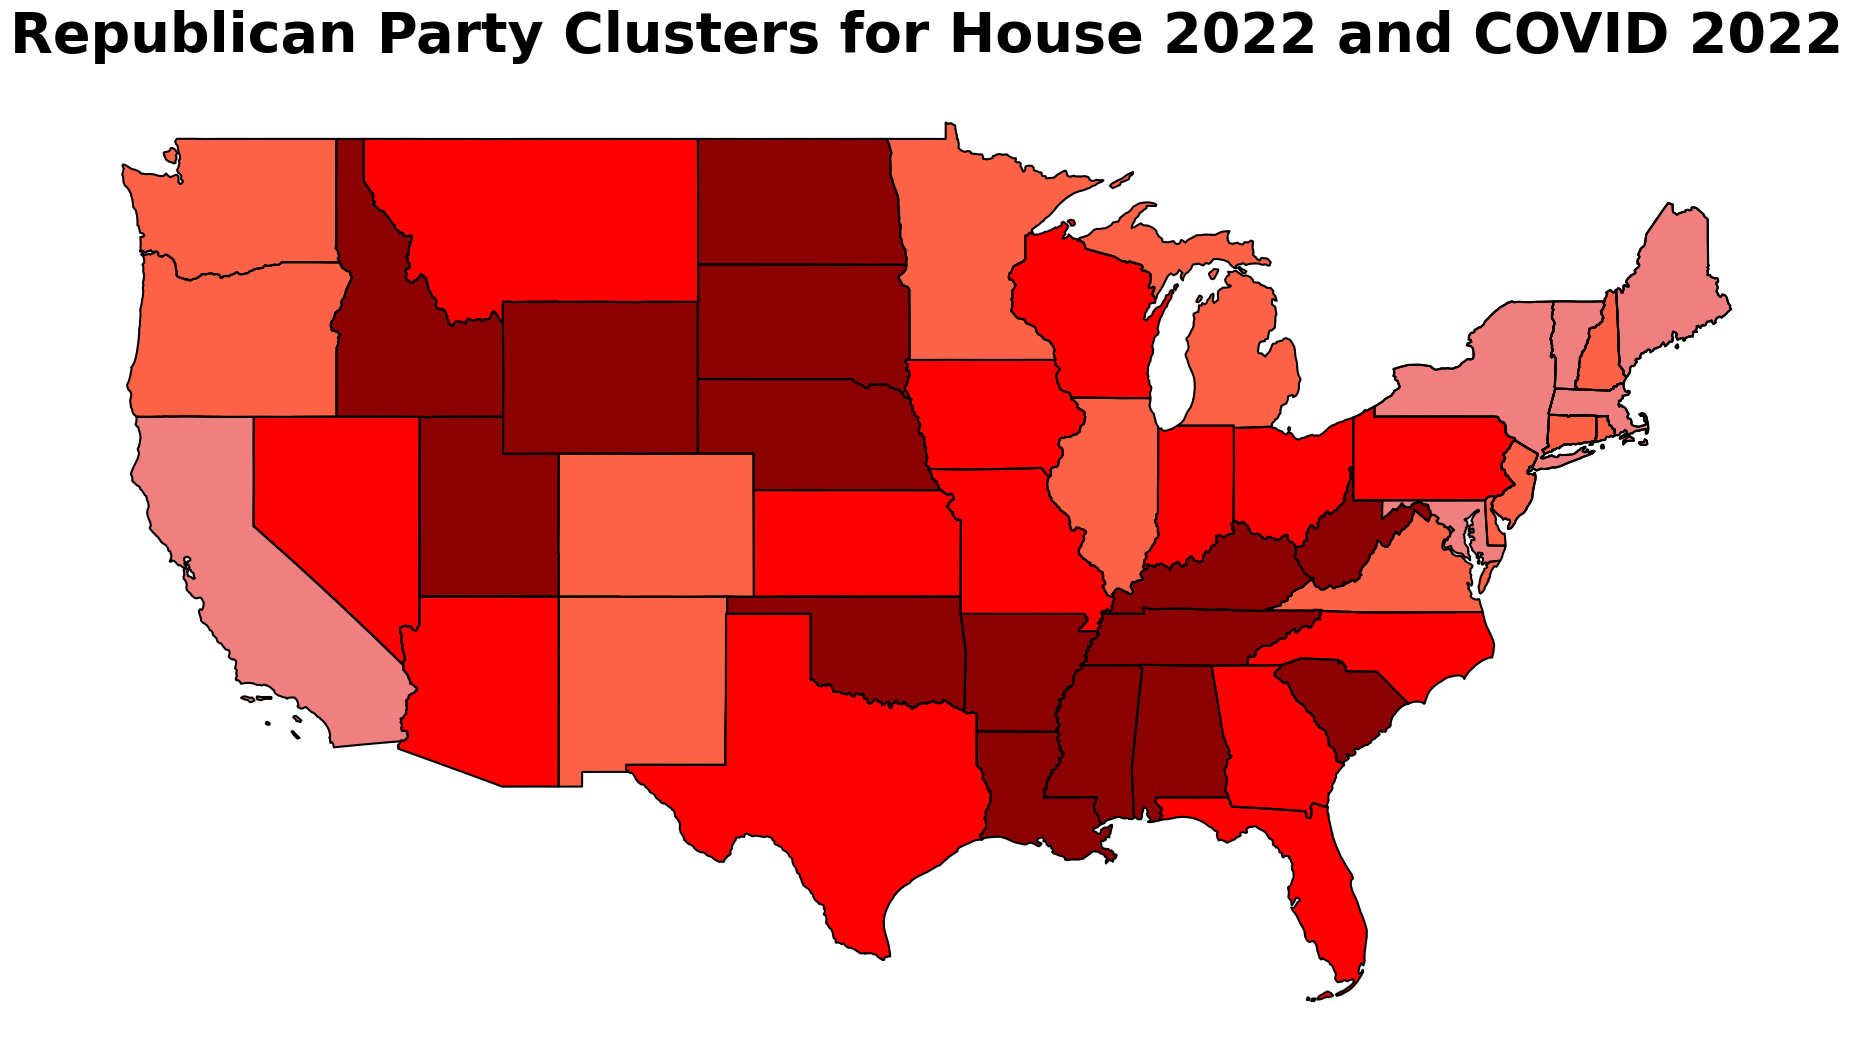

In [74]:
make_map(best_cluster, best_colors, "Republican Party Clusters for House 2022 and COVID 2022")

c:\Users\meowm\anaconda3\envs\GPD\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


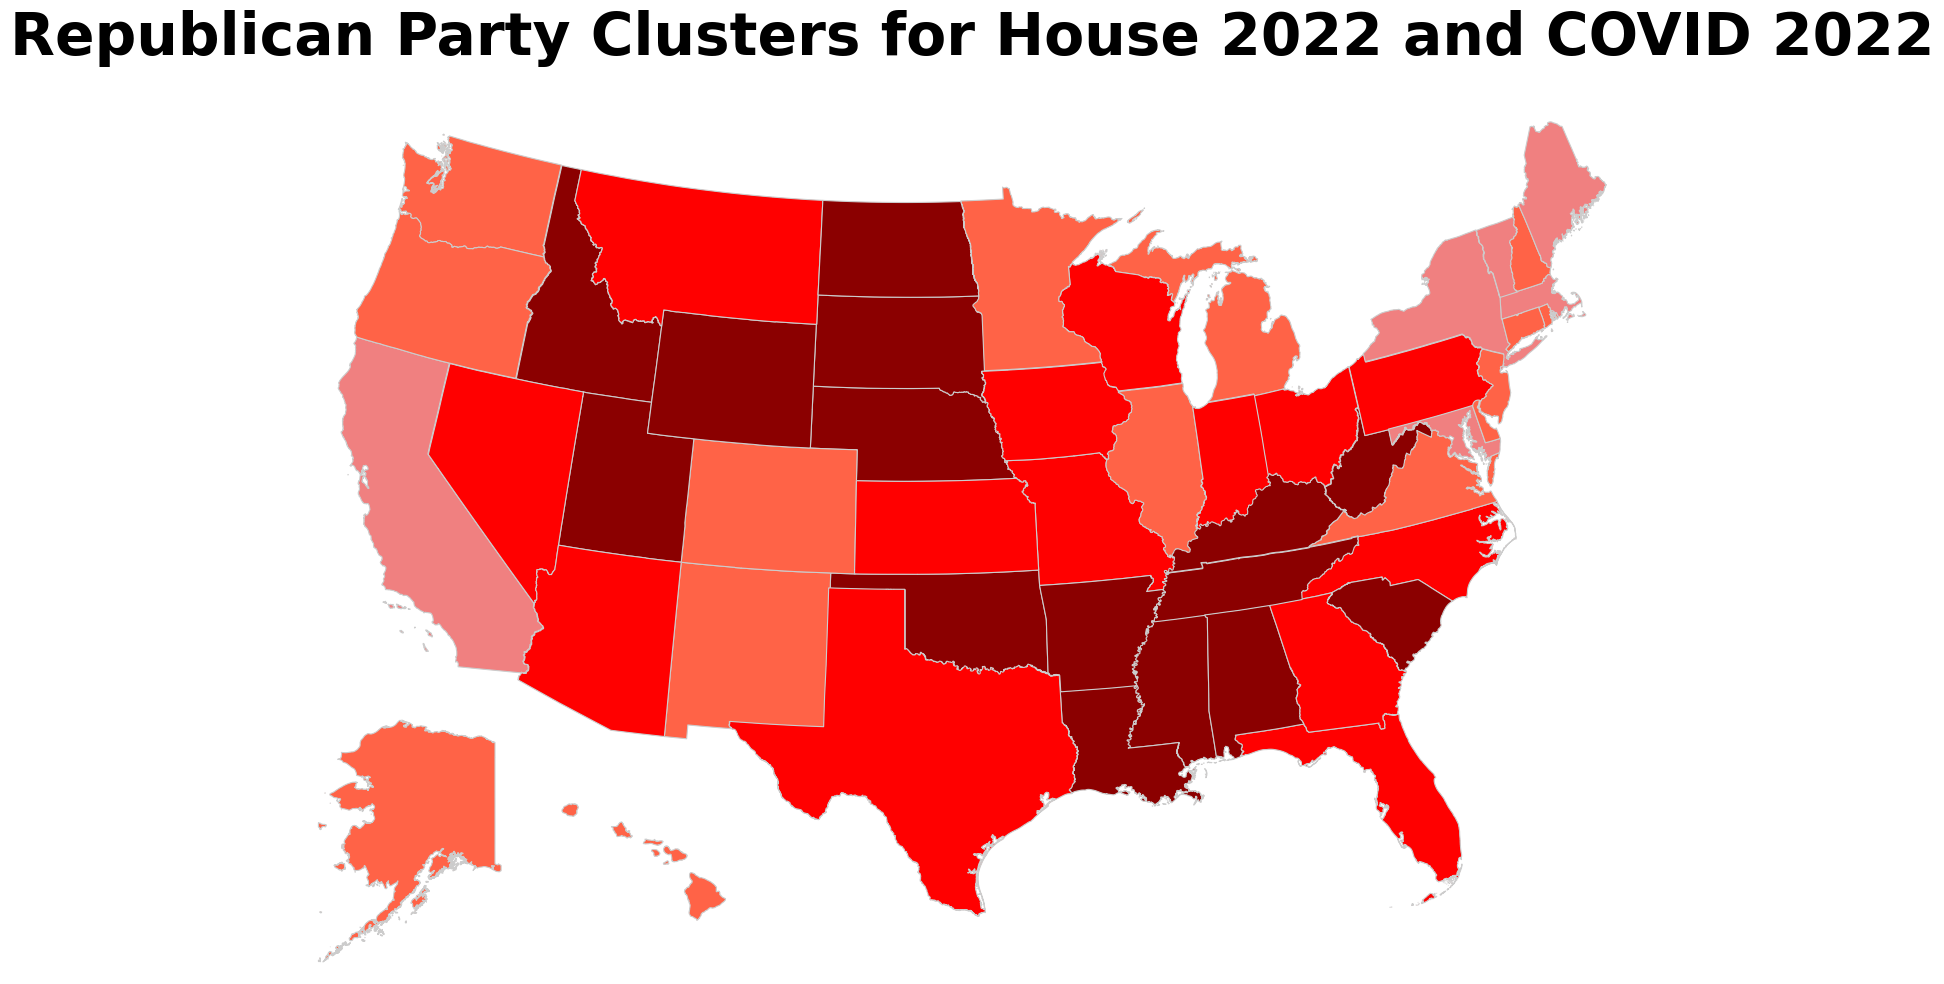

In [75]:
make_map_AK_HI(best_cluster, best_colors, "Republican Party Clusters for House 2022 and COVID 2022")